In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt5
%matplotlib inline

nx = 9 #number of inside corners in x
ny = 6 #umber of inside corners in y

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
    




In [79]:
def cal_undistort(img, objpoints, imgpoints):
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0,255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient=='x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient=='y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    #plt.imshow(sxbinary, cmap='gray')
    # 6) Return this mask as your binary_output image
    return sxbinary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) Calculate the magnitude 
    abs_sobelxy = np.sqrt(sobelx * sobelx + sobely * sobely) 
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    # 5) Create a binary mask where mag thresholds are met
    
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    
    # 6) Return this mask as your binary_output image
   
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

#combining the three methods: 
def combine_grad_thresh(img):
    # Apply each of the thresholding functions
    # Choose a Sobel kernel size
    ksize = 9 # Choose a larger odd number to smooth gradient measurements
    # Run the function
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(20, 100))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=3, thresh=(20, 100))
    mag_binary = mag_thresh(image, sobel_kernel=3, mag_thresh=(30, 100))
    dir_binary = dir_threshold(image, sobel_kernel=11, thresh=(0.7, 1.3))

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined


# Color thresholding, taking the saturation channel from the HLS color space
def hls_saturation(img, thresh=(90, 220)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s = hls[:,:,2]
    binary_s = np.zeros_like(s)
    binary_s[(s >= thresh[0]) & (s <= thresh[1])] = 1
    return binary_s

def rgb_channel_r(img, thresh=(150, 255)):
    R = img[:,:,2]
    G = img[:,:,1]
    B = img[:,:,0]
    binary_R = np.zeros_like(R)
    binary_R[(R >= thresh[0]) & (R <= thresh[1])] = 1
    return binary_R

def calc_points(image_size):
   
    top_left = [570,470]
    top_right = [720, 470]
    bottom_right = [1130,720]
    bottom_left = [200,720]
    source = np.float32([bottom_left,bottom_right,top_left,top_right])
    
    top_left_dst = [320,0]
    top_right_dst = [980,0]
    bottom_right_dst = [980,720]
    bottom_left_dst = [320,720]
    dst = np.float32([bottom_left_dst,bottom_right_dst,top_left_dst,top_right_dst])
    
    return dst, source


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import cv2

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids




In [106]:

def finding_lanes(binary_warped):
  
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    #plt.plot(histogram)
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    #histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 18
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    
    # Create an image to draw on and an image to show the selection window
    #out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    #plt.imshow(out_img)
    #plt.show()
    
     # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    #plt.imshow(result)
    #plt.show()
    
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    #plt.xlim(0, 1280)
    #plt.ylim(720, 0)
    
    return left_fitx, right_fitx, ploty, result
    
    

In [58]:
def measure_curve(leftx, rightx, ploty):
    
    quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
    y_eval = np.max(ploty)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m
    return left_curverad, right_curverad


In [88]:
def pipeline(img):
    image = cal_undistort(img, objpoints, imgpoints)
    combined = combine_grad_thresh(image)
    hls = hls_saturation(image, thresh=(160,255))
    r = rgb_channel_r(image)

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(combined)
    combined_binary[(hls > 0) | (combined > 0)] = 1
    #combined_binary[(gradx == 1)  | (hls == 1) | (r == 1) ] = 1

    dst, source = calc_points(image.shape)

    M = cv2.getPerspectiveTransform(source, dst)
    Minv = cv2.getPerspectiveTransform(dst, source)

    img_size = (combined_binary.shape[0], combined_binary.shape[1])
    warped = cv2.warpPerspective(combined_binary, M, gray.shape[::-1] , flags=cv2.INTER_LINEAR)

    # window settings
    window_width = 50 
    window_height = 80 # Break image into 9 vertical layers since image height is 720
    margin = 100 # How much to slide left and right for searching

    leftx, rightx, ploty, result = finding_lanes(warped)

    measure_curve(leftx,rightx,ploty)

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([leftx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([rightx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    return result
   


    

2513.34094909 m 418.7112811 m


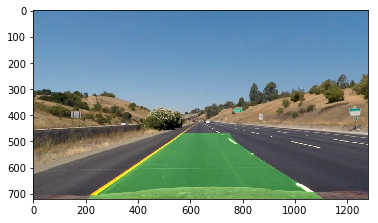

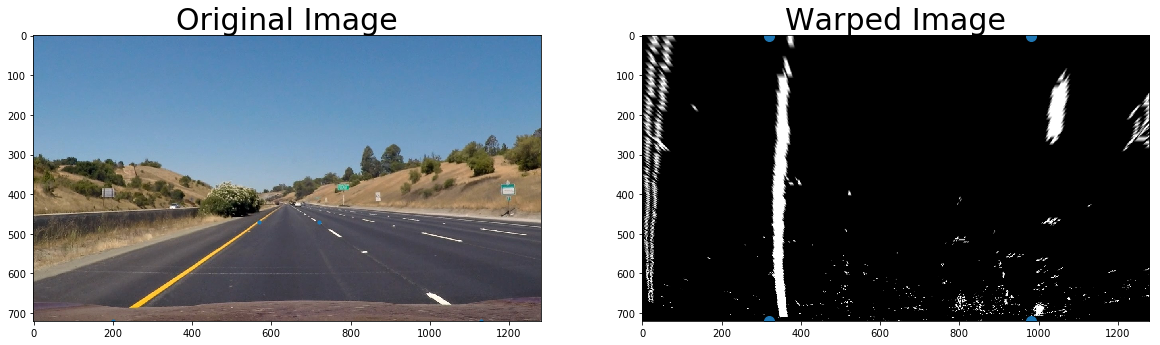

In [107]:

img = mpimg.imread('test_images/straight_lines1.jpg')

# Display the final results
#plt.imshow(result, cmap='gray')
#plt.title('window fitting results')
#plt.show()
result = pipeline(img)

plt.imshow(result)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.scatter([570,720,200,1130],[470,470,720,720],s =10)
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)

ax2.scatter([320,980,320,980],[1,1,720,720],s =100)
ax2.imshow(warped, cmap='gray')
ax2.set_title('Warped Image', fontsize=30)




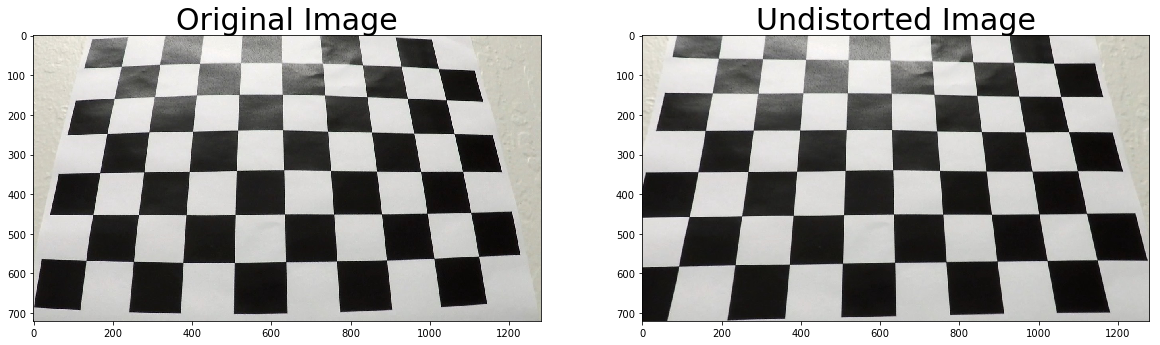

In [94]:

img = mpimg.imread('./camera_cal/calibration3.jpg')
image = cal_undistort(img, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
#ax1.scatter([570,720,200,1130],[470,470,720,720],s =10)
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)

#ax2.scatter([320,980,320,980],[1,1,720,720],s =100)
ax2.imshow(image, cmap='gray')
ax2.set_title('Undistorted Image', fontsize=30)

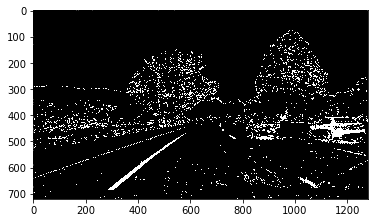

In [100]:
image = mpimg.imread('./test_images/test1.jpg')    
combined = combine_grad_thresh(image)
hls = hls_saturation(image, thresh=(160,255))

# Combine the two binary thresholds
combined_binary = np.zeros_like(combined)
combined_binary[(hls > 0) | (combined > 0)] = 1

plt.imshow(combined_binary, cmap='gray')


In [92]:

### Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

result_output = 'result.mp4'
clip1 = VideoFileClip("project_video.mp4")
result_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time result_clip.write_videofile(result_output, audio=False)

1223.75094662 m 1189.58055001 m
[MoviePy] >>>> Building video result.mp4
[MoviePy] Writing video result.mp4



  0%|          | 1/1261 [00:01<26:32,  1.26s/it]

1223.75094662 m 1189.58055001 m



  0%|          | 2/1261 [00:02<25:59,  1.24s/it]

1080.69975747 m 2291.97104544 m



  0%|          | 3/1261 [00:03<25:40,  1.22s/it]

1032.99429433 m 2122.90521727 m



  0%|          | 4/1261 [00:04<25:13,  1.20s/it]

983.292623325 m 449.25198538 m



  0%|          | 5/1261 [00:05<24:30,  1.17s/it]

948.542183025 m 342.940151674 m



  0%|          | 6/1261 [00:06<23:56,  1.14s/it]

946.06392698 m 281.290475036 m



  1%|          | 7/1261 [00:07<23:12,  1.11s/it]

946.5351817 m 329.686860223 m



  1%|          | 8/1261 [00:09<23:44,  1.14s/it]

983.977805932 m 579.965080472 m



  1%|          | 9/1261 [00:10<25:02,  1.20s/it]

1042.3478936 m 504.048682869 m



  1%|          | 10/1261 [00:11<25:41,  1.23s/it]

1050.30200131 m 628.269355384 m



  1%|          | 11/1261 [00:12<25:07,  1.21s/it]

971.09736609 m 781.403546037 m



  1%|          | 12/1261 [00:14<25:32,  1.23s/it]

1020.96347764 m 973.592051773 m



  1%|          | 13/1261 [00:15<24:24,  1.17s/it]

1010.40736499 m 1804.36303402 m



  1%|          | 14/1261 [00:16<23:50,  1.15s/it]

981.224560326 m 3383.52100027 m



  1%|          | 15/1261 [00:17<23:20,  1.12s/it]

978.617856478 m 4060.75617862 m



  1%|▏         | 16/1261 [00:18<22:49,  1.10s/it]

1065.58101352 m 605.491164128 m



  1%|▏         | 17/1261 [00:19<22:49,  1.10s/it]

1054.17428944 m 278.078347723 m



  1%|▏         | 18/1261 [00:21<24:35,  1.19s/it]

1103.49593224 m 208.269568712 m



  2%|▏         | 19/1261 [00:22<25:12,  1.22s/it]

1262.49495386 m 213.542654277 m



  2%|▏         | 20/1261 [00:23<24:41,  1.19s/it]

1423.00102663 m 271.942484638 m



  2%|▏         | 21/1261 [00:24<24:06,  1.17s/it]

1566.00392917 m 382.124932856 m



  2%|▏         | 22/1261 [00:25<25:11,  1.22s/it]

1892.92049588 m 443.198614008 m



  2%|▏         | 23/1261 [00:27<25:12,  1.22s/it]

1541.85211917 m 542.325247238 m



  2%|▏         | 24/1261 [00:28<25:20,  1.23s/it]

1982.70538658 m 771.714255939 m



  2%|▏         | 25/1261 [00:29<26:49,  1.30s/it]

1763.97844234 m 907.825586074 m



  2%|▏         | 26/1261 [00:31<26:25,  1.28s/it]

1541.85211917 m 1246.47050125 m



  2%|▏         | 27/1261 [00:32<25:10,  1.22s/it]

1541.85211917 m 1855.15614604 m



  2%|▏         | 28/1261 [00:33<24:06,  1.17s/it]

1541.85211917 m 2130.73031113 m



  2%|▏         | 29/1261 [00:34<23:23,  1.14s/it]

1412.74191006 m 1066.77311611 m



  2%|▏         | 30/1261 [00:35<23:26,  1.14s/it]

1203.88439888 m 392.961674651 m



  2%|▏         | 31/1261 [00:36<23:15,  1.13s/it]

1104.54203609 m 245.584618233 m



  3%|▎         | 32/1261 [00:37<23:00,  1.12s/it]

1066.95121495 m 245.119117418 m



  3%|▎         | 33/1261 [00:38<23:35,  1.15s/it]

1042.76679816 m 39.8940685379 m



  3%|▎         | 34/1261 [00:40<25:28,  1.25s/it]

994.449346341 m 408.549714165 m



  3%|▎         | 35/1261 [00:41<25:10,  1.23s/it]

988.780488371 m 500.596390716 m



  3%|▎         | 36/1261 [00:42<24:28,  1.20s/it]

948.741615491 m 667.42333147 m



  3%|▎         | 37/1261 [00:43<23:56,  1.17s/it]

944.678138197 m 801.819337869 m



  3%|▎         | 38/1261 [00:45<24:32,  1.20s/it]

917.323452353 m 1043.25067976 m



  3%|▎         | 39/1261 [00:46<24:46,  1.22s/it]

869.344579497 m 1228.88716432 m



  3%|▎         | 40/1261 [00:47<26:15,  1.29s/it]

850.285403741 m 1265.45140386 m



  3%|▎         | 41/1261 [00:49<26:51,  1.32s/it]

831.033041158 m 916.468057815 m



  3%|▎         | 42/1261 [00:50<25:32,  1.26s/it]

826.861451469 m 427.282544383 m



  3%|▎         | 43/1261 [00:51<24:33,  1.21s/it]

768.651387658 m 308.562987812 m



  3%|▎         | 44/1261 [00:52<23:53,  1.18s/it]

793.597258562 m 239.493554938 m



  4%|▎         | 45/1261 [00:53<23:21,  1.15s/it]

791.802703159 m 250.483895224 m



  4%|▎         | 46/1261 [00:54<22:39,  1.12s/it]

790.289065629 m 399.232972074 m



  4%|▎         | 47/1261 [00:55<22:08,  1.09s/it]

789.723423396 m 442.043847053 m



  4%|▍         | 48/1261 [00:56<22:09,  1.10s/it]

773.813872824 m 521.511522872 m



  4%|▍         | 49/1261 [00:58<23:26,  1.16s/it]

817.84409603 m 756.425386205 m



  4%|▍         | 50/1261 [00:59<23:34,  1.17s/it]

817.863501502 m 968.294611986 m



  4%|▍         | 51/1261 [01:00<23:00,  1.14s/it]

844.139905626 m 1102.01018099 m



  4%|▍         | 52/1261 [01:01<22:28,  1.12s/it]

872.891543944 m 1327.24539001 m



  4%|▍         | 53/1261 [01:02<22:06,  1.10s/it]

903.83515359 m 1079.67198256 m



  4%|▍         | 54/1261 [01:03<22:05,  1.10s/it]

948.375503326 m 506.420778242 m



  4%|▍         | 55/1261 [01:04<22:38,  1.13s/it]

1013.33465749 m 311.805732774 m



  4%|▍         | 56/1261 [01:05<22:22,  1.11s/it]

1089.26447254 m 246.301323632 m



  5%|▍         | 57/1261 [01:06<22:06,  1.10s/it]

1153.96466237 m 234.771961131 m



  5%|▍         | 58/1261 [01:08<23:10,  1.16s/it]

1330.937884 m 287.258054798 m



  5%|▍         | 59/1261 [01:10<27:30,  1.37s/it]

1584.39968775 m 364.474715748 m



  5%|▍         | 60/1261 [01:11<27:54,  1.39s/it]

1683.19255788 m 401.794318035 m



  5%|▍         | 61/1261 [01:12<27:22,  1.37s/it]

1870.46418488 m 533.520267438 m



  5%|▍         | 62/1261 [01:14<26:42,  1.34s/it]

1714.5023044 m 677.450943961 m



  5%|▍         | 63/1261 [01:15<25:56,  1.30s/it]

1658.81536485 m 770.535508014 m



  5%|▌         | 64/1261 [01:16<24:37,  1.23s/it]

1502.36383025 m 1186.3347796 m



  5%|▌         | 65/1261 [01:17<23:28,  1.18s/it]

1389.40169665 m 1296.06104641 m



  5%|▌         | 66/1261 [01:18<23:13,  1.17s/it]

1202.37714019 m 723.820418485 m



  5%|▌         | 67/1261 [01:19<23:06,  1.16s/it]

1141.22045201 m 272.876604128 m



  5%|▌         | 68/1261 [01:20<23:21,  1.18s/it]

1008.25491351 m 221.568930856 m



  5%|▌         | 69/1261 [01:22<23:10,  1.17s/it]

921.500239516 m 210.971271486 m



  6%|▌         | 70/1261 [01:23<23:04,  1.16s/it]

899.396010131 m 224.458142339 m



  6%|▌         | 71/1261 [01:24<24:13,  1.22s/it]

878.854190821 m 324.925009534 m



  6%|▌         | 72/1261 [01:25<23:55,  1.21s/it]

875.603666137 m 359.161948559 m



  6%|▌         | 73/1261 [01:26<22:59,  1.16s/it]

913.379837967 m 402.965576734 m



  6%|▌         | 74/1261 [01:27<22:30,  1.14s/it]

980.75095445 m 519.048435392 m



  6%|▌         | 75/1261 [01:28<21:54,  1.11s/it]

1020.35837108 m 655.65366944 m



  6%|▌         | 76/1261 [01:30<22:49,  1.16s/it]

1151.25524906 m 877.446105707 m



  6%|▌         | 77/1261 [01:31<22:22,  1.13s/it]

1446.4754207 m 1339.6252591 m



  6%|▌         | 78/1261 [01:32<22:04,  1.12s/it]

1586.10814097 m 3923.68105448 m



  6%|▋         | 79/1261 [01:33<21:41,  1.10s/it]

2002.26905642 m 1962.69834149 m



  6%|▋         | 80/1261 [01:34<21:28,  1.09s/it]

1861.17993023 m 429.522849961 m



  6%|▋         | 81/1261 [01:35<21:16,  1.08s/it]

2028.05898717 m 255.235146181 m



  7%|▋         | 82/1261 [01:36<21:08,  1.08s/it]

2481.37598519 m 239.11477797 m



  7%|▋         | 83/1261 [01:37<22:06,  1.13s/it]

2393.27334489 m 1060.52880976 m



  7%|▋         | 84/1261 [01:38<22:01,  1.12s/it]

2337.57562554 m 338.398708357 m



  7%|▋         | 85/1261 [01:40<21:49,  1.11s/it]

2063.21140862 m 401.804852812 m



  7%|▋         | 86/1261 [01:41<21:45,  1.11s/it]

1841.23215189 m 469.2562839 m



  7%|▋         | 87/1261 [01:42<23:21,  1.19s/it]

1689.51377545 m 645.698611188 m



  7%|▋         | 88/1261 [01:43<23:10,  1.19s/it]

1550.93566331 m 733.818854663 m



  7%|▋         | 89/1261 [01:44<22:38,  1.16s/it]

1322.89528386 m 981.243837899 m



  7%|▋         | 90/1261 [01:45<22:19,  1.14s/it]

1162.41170699 m 1548.80223077 m



  7%|▋         | 91/1261 [01:47<22:12,  1.14s/it]

1161.8361582 m 2367.77309723 m



  7%|▋         | 92/1261 [01:48<21:57,  1.13s/it]

1136.93304251 m 344.913668152 m



  7%|▋         | 93/1261 [01:49<21:39,  1.11s/it]

1043.36412501 m 222.908457815 m



  7%|▋         | 94/1261 [01:50<21:42,  1.12s/it]

974.042485913 m 201.462931812 m



  8%|▊         | 95/1261 [01:51<21:33,  1.11s/it]

966.16277643 m 212.979050228 m



  8%|▊         | 96/1261 [01:52<21:29,  1.11s/it]

959.899053699 m 322.336979625 m



  8%|▊         | 97/1261 [01:53<23:32,  1.21s/it]

971.52615544 m 350.311346146 m



  8%|▊         | 98/1261 [01:55<22:43,  1.17s/it]

1006.35627389 m 377.392182557 m



  8%|▊         | 99/1261 [01:56<22:19,  1.15s/it]

1032.6753975 m 516.235753837 m



  8%|▊         | 100/1261 [01:57<22:35,  1.17s/it]

1026.83183731 m 616.331802086 m



  8%|▊         | 101/1261 [01:58<23:49,  1.23s/it]

1083.17746472 m 811.476466092 m



  8%|▊         | 102/1261 [01:59<23:18,  1.21s/it]

1141.0440067 m 1439.20711072 m



  8%|▊         | 103/1261 [02:00<22:45,  1.18s/it]

1164.5905634 m 1178.66154961 m



  8%|▊         | 104/1261 [02:02<22:27,  1.16s/it]

1218.78642587 m 913.938126716 m



  8%|▊         | 105/1261 [02:03<22:16,  1.16s/it]

1322.98572007 m 415.826852841 m



  8%|▊         | 106/1261 [02:04<22:24,  1.16s/it]

1222.51384613 m 275.851346338 m



  8%|▊         | 107/1261 [02:05<22:11,  1.15s/it]

1199.83236162 m 261.902324962 m



  9%|▊         | 108/1261 [02:06<21:41,  1.13s/it]

1139.28766657 m 39.0254732657 m



  9%|▊         | 109/1261 [02:07<21:30,  1.12s/it]

1148.35148433 m 375.128292633 m



  9%|▊         | 110/1261 [02:08<21:27,  1.12s/it]

1144.75824215 m 396.048646816 m



  9%|▉         | 111/1261 [02:09<21:10,  1.11s/it]

1137.87574155 m 474.094469463 m



  9%|▉         | 112/1261 [02:11<21:05,  1.10s/it]

1124.43990372 m 699.110969712 m



  9%|▉         | 113/1261 [02:12<21:17,  1.11s/it]

1134.8278784 m 815.417973472 m



  9%|▉         | 114/1261 [02:13<20:54,  1.09s/it]

1119.02068825 m 988.81961298 m



  9%|▉         | 115/1261 [02:14<20:45,  1.09s/it]

1048.1417735 m 1311.25840173 m



  9%|▉         | 116/1261 [02:15<20:43,  1.09s/it]

1038.6283392 m 1427.03350533 m



  9%|▉         | 117/1261 [02:16<20:40,  1.08s/it]

1005.3737892 m 559.20335523 m



  9%|▉         | 118/1261 [02:17<20:38,  1.08s/it]

980.347005198 m 300.746982342 m



  9%|▉         | 119/1261 [02:18<20:44,  1.09s/it]

998.880053081 m 261.869569957 m



 10%|▉         | 120/1261 [02:19<20:57,  1.10s/it]

969.436427062 m 275.127287859 m



 10%|▉         | 121/1261 [02:20<20:44,  1.09s/it]

980.116924886 m 289.453492897 m



 10%|▉         | 122/1261 [02:22<21:46,  1.15s/it]

971.769900805 m 369.938192731 m



 10%|▉         | 123/1261 [02:23<21:52,  1.15s/it]

936.62010117 m 453.16729175 m



 10%|▉         | 124/1261 [02:24<21:28,  1.13s/it]

939.381235443 m 615.726194648 m



 10%|▉         | 125/1261 [02:25<21:08,  1.12s/it]

939.476409585 m 733.354019646 m



 10%|▉         | 126/1261 [02:26<21:14,  1.12s/it]

915.248268778 m 980.840969716 m



 10%|█         | 127/1261 [02:27<21:14,  1.12s/it]

895.426728633 m 1173.46261469 m



 10%|█         | 128/1261 [02:28<21:12,  1.12s/it]

900.984150138 m 1417.90696512 m



 10%|█         | 129/1261 [02:29<21:20,  1.13s/it]

859.787755819 m 725.705491816 m



 10%|█         | 130/1261 [02:31<23:53,  1.27s/it]

894.360724752 m 342.208771428 m



 10%|█         | 131/1261 [02:32<23:14,  1.23s/it]

896.033195837 m 251.59634217 m



 10%|█         | 132/1261 [02:33<22:33,  1.20s/it]

932.645127341 m 235.353584016 m



 11%|█         | 133/1261 [02:35<22:33,  1.20s/it]

1051.69539682 m 250.778001132 m



 11%|█         | 134/1261 [02:36<21:48,  1.16s/it]

1118.93923412 m 402.723900309 m



 11%|█         | 135/1261 [02:37<21:21,  1.14s/it]

1204.81948909 m 417.2668615 m



 11%|█         | 136/1261 [02:38<20:54,  1.12s/it]

1276.974095 m 498.103495607 m



 11%|█         | 137/1261 [02:39<20:37,  1.10s/it]

1363.81612584 m 728.908697897 m



 11%|█         | 138/1261 [02:40<21:16,  1.14s/it]

1394.02405537 m 911.929325319 m



 11%|█         | 139/1261 [02:41<20:47,  1.11s/it]

1439.05648523 m 1229.99091818 m



 11%|█         | 140/1261 [02:42<21:52,  1.17s/it]

1494.03774043 m 1993.32398529 m



 11%|█         | 141/1261 [02:44<21:55,  1.17s/it]

1395.76663094 m 20878.2406678 m



 11%|█▏        | 142/1261 [02:45<21:54,  1.18s/it]

1400.17177782 m 1008.08029558 m



 11%|█▏        | 143/1261 [02:46<21:54,  1.18s/it]

1167.26813681 m 310.53528173 m



 11%|█▏        | 144/1261 [02:47<21:04,  1.13s/it]

1115.55381873 m 239.455248222 m



 11%|█▏        | 145/1261 [02:48<20:35,  1.11s/it]

1058.90988112 m 240.9543354 m



 12%|█▏        | 146/1261 [02:49<20:16,  1.09s/it]

1063.27496245 m 277.104340493 m



 12%|█▏        | 147/1261 [02:50<21:09,  1.14s/it]

1068.48607269 m 386.681493104 m



 12%|█▏        | 148/1261 [02:51<21:12,  1.14s/it]

1161.91014066 m 448.52730786 m



 12%|█▏        | 149/1261 [02:53<21:41,  1.17s/it]

1168.15103642 m 628.197304756 m



 12%|█▏        | 150/1261 [02:54<21:15,  1.15s/it]

1279.94101694 m 761.334673886 m



 12%|█▏        | 151/1261 [02:55<21:36,  1.17s/it]

1365.24453691 m 2434.11565264 m



 12%|█▏        | 152/1261 [02:56<21:23,  1.16s/it]

1447.47307651 m 1167.94219108 m



 12%|█▏        | 153/1261 [02:57<20:43,  1.12s/it]

1494.36526892 m 1264.8537684 m



 12%|█▏        | 154/1261 [02:58<21:01,  1.14s/it]

1467.20543123 m 803.580244523 m



 12%|█▏        | 155/1261 [03:00<21:06,  1.14s/it]

1394.51302374 m 438.125711399 m



 12%|█▏        | 156/1261 [03:01<21:42,  1.18s/it]

1515.36744186 m 324.13020632 m



 12%|█▏        | 157/1261 [03:02<23:06,  1.26s/it]

1399.37548463 m 287.07477612 m



 13%|█▎        | 158/1261 [03:04<23:36,  1.28s/it]

1230.43508694 m 277.208171693 m



 13%|█▎        | 159/1261 [03:05<23:28,  1.28s/it]

1236.36823482 m 367.407987962 m



 13%|█▎        | 160/1261 [03:07<25:48,  1.41s/it]

1115.14065574 m 443.004452355 m



 13%|█▎        | 161/1261 [03:08<26:38,  1.45s/it]

1073.8399544 m 516.161870956 m



 13%|█▎        | 162/1261 [03:10<29:03,  1.59s/it]

1050.77734645 m 720.19329536 m



 13%|█▎        | 163/1261 [03:11<27:08,  1.48s/it]

1146.75507316 m 959.641705913 m



 13%|█▎        | 164/1261 [03:12<25:01,  1.37s/it]

1039.17907641 m 1120.04353258 m



 13%|█▎        | 165/1261 [03:13<23:24,  1.28s/it]

1020.27812932 m 1313.15019249 m



 13%|█▎        | 166/1261 [03:14<22:13,  1.22s/it]

1019.10699823 m 1120.05259685 m



 13%|█▎        | 167/1261 [03:16<21:28,  1.18s/it]

1013.95377174 m 411.440693816 m



 13%|█▎        | 168/1261 [03:17<21:28,  1.18s/it]

994.299710106 m 332.539171508 m



 13%|█▎        | 169/1261 [03:18<21:21,  1.17s/it]

976.501556066 m 253.174796724 m



 13%|█▎        | 170/1261 [03:20<24:22,  1.34s/it]

1065.70264125 m 252.23302873 m



 14%|█▎        | 171/1261 [03:21<25:12,  1.39s/it]

975.738655137 m 259.791174974 m



 14%|█▎        | 172/1261 [03:22<24:17,  1.34s/it]

1040.38678585 m 371.370263313 m



 14%|█▎        | 173/1261 [03:24<23:16,  1.28s/it]

1038.44811246 m 425.114971784 m



 14%|█▍        | 174/1261 [03:25<22:30,  1.24s/it]

1135.57924554 m 574.350599277 m



 14%|█▍        | 175/1261 [03:26<22:02,  1.22s/it]

1280.01924695 m 687.008167793 m



 14%|█▍        | 176/1261 [03:27<22:24,  1.24s/it]

1372.37607379 m 868.464392298 m



 14%|█▍        | 177/1261 [03:29<23:43,  1.31s/it]

1484.99283766 m 1305.10022475 m



 14%|█▍        | 178/1261 [03:30<23:13,  1.29s/it]

1620.90535329 m 1167.68311874 m



 14%|█▍        | 179/1261 [03:31<22:16,  1.24s/it]

1868.37381067 m 704.935012557 m



 14%|█▍        | 180/1261 [03:32<21:41,  1.20s/it]

1716.69844969 m 391.31156784 m



 14%|█▍        | 181/1261 [03:33<22:07,  1.23s/it]

1428.8360128 m 247.140392241 m



 14%|█▍        | 182/1261 [03:34<21:28,  1.19s/it]

1362.2886638 m 259.143779231 m



 15%|█▍        | 183/1261 [03:36<22:03,  1.23s/it]

1416.21497489 m 283.250242633 m



 15%|█▍        | 184/1261 [03:37<22:01,  1.23s/it]

1077.59354541 m 386.360671249 m



 15%|█▍        | 185/1261 [03:38<22:33,  1.26s/it]

978.694215287 m 446.042881557 m



 15%|█▍        | 186/1261 [03:39<21:57,  1.23s/it]

824.487158053 m 583.278277036 m



 15%|█▍        | 187/1261 [03:41<23:32,  1.32s/it]

745.212878058 m 686.020699444 m



 15%|█▍        | 188/1261 [03:42<22:33,  1.26s/it]

701.70637277 m 858.116503191 m



 15%|█▍        | 189/1261 [03:43<21:48,  1.22s/it]

696.278510528 m 1298.85444221 m



 15%|█▌        | 190/1261 [03:44<21:06,  1.18s/it]

714.293981991 m 1281.85856273 m



 15%|█▌        | 191/1261 [03:45<20:41,  1.16s/it]

726.849820146 m 908.182751267 m



 15%|█▌        | 192/1261 [03:47<20:07,  1.13s/it]

761.312835848 m 360.810467784 m



 15%|█▌        | 193/1261 [03:48<20:35,  1.16s/it]

763.02029032 m 254.442049777 m



 15%|█▌        | 194/1261 [03:49<20:34,  1.16s/it]

788.653563943 m 254.318836315 m



 15%|█▌        | 195/1261 [03:50<20:14,  1.14s/it]

802.578782068 m 243.790245323 m



 16%|█▌        | 196/1261 [03:51<19:49,  1.12s/it]

860.695573872 m 336.774457963 m



 16%|█▌        | 197/1261 [03:52<20:16,  1.14s/it]

1007.16651337 m 413.286920607 m



 16%|█▌        | 198/1261 [03:53<19:47,  1.12s/it]

1013.7270663 m 544.802117362 m



 16%|█▌        | 199/1261 [03:54<19:27,  1.10s/it]

935.41656584 m 857.232867835 m



 16%|█▌        | 200/1261 [03:56<19:46,  1.12s/it]

942.86950216 m 915.946143567 m



 16%|█▌        | 201/1261 [03:57<19:49,  1.12s/it]

1076.32999747 m 1242.71833707 m



 16%|█▌        | 202/1261 [03:58<19:52,  1.13s/it]

1227.87641481 m 1331.42833312 m



 16%|█▌        | 203/1261 [03:59<19:39,  1.11s/it]

1237.0520075 m 996.039961044 m



 16%|█▌        | 204/1261 [04:00<19:28,  1.11s/it]

1060.33134117 m 484.914230351 m



 16%|█▋        | 205/1261 [04:01<19:22,  1.10s/it]

1056.38953664 m 308.238718844 m



 16%|█▋        | 206/1261 [04:02<19:07,  1.09s/it]

1058.40892153 m 237.90615971 m



 16%|█▋        | 207/1261 [04:04<21:28,  1.22s/it]

1088.53149223 m 222.312627047 m



 16%|█▋        | 208/1261 [04:05<21:20,  1.22s/it]

975.812266267 m 308.290180539 m



 17%|█▋        | 209/1261 [04:06<20:49,  1.19s/it]

1103.11875344 m 369.883886173 m



 17%|█▋        | 210/1261 [04:07<20:01,  1.14s/it]

963.165925581 m 433.728268764 m



 17%|█▋        | 211/1261 [04:08<19:46,  1.13s/it]

1067.36035992 m 607.514406312 m



 17%|█▋        | 212/1261 [04:10<21:01,  1.20s/it]

992.07231923 m 745.071563098 m



 17%|█▋        | 213/1261 [04:11<20:30,  1.17s/it]

883.42990093 m 914.698878019 m



 17%|█▋        | 214/1261 [04:12<20:10,  1.16s/it]

853.003145435 m 1161.89236444 m



 17%|█▋        | 215/1261 [04:13<19:45,  1.13s/it]

785.762637228 m 1259.9740129 m



 17%|█▋        | 216/1261 [04:14<19:47,  1.14s/it]

794.829644237 m 781.931265608 m



 17%|█▋        | 217/1261 [04:15<19:30,  1.12s/it]

765.694113651 m 312.333824274 m



 17%|█▋        | 218/1261 [04:16<19:18,  1.11s/it]

754.12942416 m 235.902521294 m



 17%|█▋        | 219/1261 [04:17<19:05,  1.10s/it]

744.765924189 m 205.779879711 m



 17%|█▋        | 220/1261 [04:18<19:00,  1.10s/it]

793.895550799 m 225.604909217 m



 18%|█▊        | 221/1261 [04:19<18:54,  1.09s/it]

818.084276313 m 311.094069743 m



 18%|█▊        | 222/1261 [04:20<18:42,  1.08s/it]

839.082955006 m 347.087643143 m



 18%|█▊        | 223/1261 [04:22<18:48,  1.09s/it]

908.983479252 m 472.770522071 m



 18%|█▊        | 224/1261 [04:23<18:51,  1.09s/it]

883.569704659 m 557.875798854 m



 18%|█▊        | 225/1261 [04:24<18:43,  1.08s/it]

933.882361267 m 699.540633871 m



 18%|█▊        | 226/1261 [04:25<18:40,  1.08s/it]

908.283736801 m 932.091722044 m



 18%|█▊        | 227/1261 [04:26<18:47,  1.09s/it]

909.79823402 m 1478.65849542 m



 18%|█▊        | 228/1261 [04:27<19:01,  1.11s/it]

992.837678079 m 1146.76924453 m



 18%|█▊        | 229/1261 [04:28<19:14,  1.12s/it]

921.046863537 m 268.59566881 m



 18%|█▊        | 230/1261 [04:29<19:13,  1.12s/it]

927.423602258 m 218.190055142 m



 18%|█▊        | 231/1261 [04:31<20:16,  1.18s/it]

978.004418834 m 194.785822557 m



 18%|█▊        | 232/1261 [04:32<19:49,  1.16s/it]

1113.93580345 m 2531.93070849 m



 18%|█▊        | 233/1261 [04:33<19:20,  1.13s/it]

1094.18114933 m 275.630307848 m



 19%|█▊        | 234/1261 [04:34<19:28,  1.14s/it]

1060.07297511 m 333.571598558 m



 19%|█▊        | 235/1261 [04:35<19:08,  1.12s/it]

1100.43569363 m 349.383220852 m



 19%|█▊        | 236/1261 [04:36<18:41,  1.09s/it]

1048.1613398 m 571.24566043 m



 19%|█▉        | 237/1261 [04:37<18:27,  1.08s/it]

985.267331887 m 683.664146688 m



 19%|█▉        | 238/1261 [04:38<18:50,  1.11s/it]

1016.1543479 m 870.403804437 m



 19%|█▉        | 239/1261 [04:39<18:36,  1.09s/it]

1037.85939184 m 1498.25223529 m



 19%|█▉        | 240/1261 [04:40<18:38,  1.10s/it]

1038.23417057 m 1585.53148357 m



 19%|█▉        | 241/1261 [04:42<19:35,  1.15s/it]

979.818275993 m 566.054774008 m



 19%|█▉        | 242/1261 [04:43<19:12,  1.13s/it]

981.016814589 m 212.279206174 m



 19%|█▉        | 243/1261 [04:44<18:46,  1.11s/it]

953.292582351 m 182.691410559 m



 19%|█▉        | 244/1261 [04:45<18:23,  1.08s/it]

958.355733738 m 38.828863209 m



 19%|█▉        | 245/1261 [04:46<18:43,  1.11s/it]

906.109748859 m 265.69326169 m



 20%|█▉        | 246/1261 [04:47<18:51,  1.11s/it]

890.475685492 m 316.880203331 m



 20%|█▉        | 247/1261 [04:48<18:51,  1.12s/it]

885.851052273 m 321.169704138 m



 20%|█▉        | 248/1261 [04:49<18:40,  1.11s/it]

857.541352591 m 559.734728558 m



 20%|█▉        | 249/1261 [04:50<18:38,  1.11s/it]

832.413922891 m 654.001737716 m



 20%|█▉        | 250/1261 [04:52<18:39,  1.11s/it]

830.695665956 m 857.613116678 m



 20%|█▉        | 251/1261 [04:53<18:23,  1.09s/it]

931.654777934 m 1521.1383814 m



 20%|█▉        | 252/1261 [04:54<18:11,  1.08s/it]

943.443492788 m 1638.8543012 m



 20%|██        | 253/1261 [04:55<18:10,  1.08s/it]

874.636252703 m 793.800409498 m



 20%|██        | 254/1261 [04:56<18:23,  1.10s/it]

918.968107147 m 352.351956661 m



 20%|██        | 255/1261 [04:57<18:37,  1.11s/it]

917.062938421 m 210.663493354 m



 20%|██        | 256/1261 [04:58<18:40,  1.11s/it]

924.404522069 m 217.58706902 m



 20%|██        | 257/1261 [04:59<19:14,  1.15s/it]

890.189668811 m 39.0417493015 m



 20%|██        | 258/1261 [05:01<18:55,  1.13s/it]

951.720969446 m 303.126687373 m



 21%|██        | 259/1261 [05:02<18:48,  1.13s/it]

967.053020246 m 359.941695678 m



 21%|██        | 260/1261 [05:03<18:51,  1.13s/it]

949.406328587 m 527.572261372 m



 21%|██        | 261/1261 [05:04<18:37,  1.12s/it]

1019.06842836 m 573.576122252 m



 21%|██        | 262/1261 [05:05<18:23,  1.10s/it]

1028.70953835 m 683.428263637 m



 21%|██        | 263/1261 [05:06<18:15,  1.10s/it]

1042.63568723 m 846.185482085 m



 21%|██        | 264/1261 [05:07<18:13,  1.10s/it]

1144.53181634 m 1214.0055496 m



 21%|██        | 265/1261 [05:08<18:13,  1.10s/it]

1050.16927639 m 850.80691296 m



 21%|██        | 266/1261 [05:09<18:16,  1.10s/it]

1035.53732499 m 330.034836505 m



 21%|██        | 267/1261 [05:10<18:09,  1.10s/it]

1024.87496858 m 241.686476363 m



 21%|██▏       | 268/1261 [05:11<17:52,  1.08s/it]

1026.77701242 m 245.102784541 m



 21%|██▏       | 269/1261 [05:13<18:11,  1.10s/it]

993.644706156 m 39.8940685379 m



 21%|██▏       | 270/1261 [05:14<18:12,  1.10s/it]

1017.70817971 m 326.741121431 m



 21%|██▏       | 271/1261 [05:15<18:02,  1.09s/it]

1025.34829118 m 382.9722596 m



 22%|██▏       | 272/1261 [05:16<18:13,  1.11s/it]

1041.2286696 m 517.545407024 m



 22%|██▏       | 273/1261 [05:17<18:13,  1.11s/it]

1067.05846704 m 632.322141837 m



 22%|██▏       | 274/1261 [05:18<18:06,  1.10s/it]

1079.62538554 m 803.067151431 m



 22%|██▏       | 275/1261 [05:19<17:49,  1.08s/it]

1157.64909581 m 1384.24665291 m



 22%|██▏       | 276/1261 [05:20<17:38,  1.08s/it]

1175.56661823 m 1197.62272416 m



 22%|██▏       | 277/1261 [05:21<17:33,  1.07s/it]

1134.54587224 m 357.696304419 m



 22%|██▏       | 278/1261 [05:22<17:28,  1.07s/it]

1131.08013961 m 289.3572753 m



 22%|██▏       | 279/1261 [05:23<17:31,  1.07s/it]

1133.63578542 m 242.440903717 m



 22%|██▏       | 280/1261 [05:24<17:29,  1.07s/it]

1153.79769341 m 250.551129548 m



 22%|██▏       | 281/1261 [05:26<17:22,  1.06s/it]

1151.64017144 m 339.87565354 m



 22%|██▏       | 282/1261 [05:27<17:36,  1.08s/it]

1175.20004691 m 381.147743596 m



 22%|██▏       | 283/1261 [05:28<17:53,  1.10s/it]

1243.94679015 m 435.030707332 m



 23%|██▎       | 284/1261 [05:29<18:11,  1.12s/it]

1351.67118471 m 627.055654817 m



 23%|██▎       | 285/1261 [05:30<18:21,  1.13s/it]

1338.86326784 m 736.224774989 m



 23%|██▎       | 286/1261 [05:31<19:03,  1.17s/it]

1294.72272317 m 33219.0730093 m



 23%|██▎       | 287/1261 [05:32<18:51,  1.16s/it]

1382.11768377 m 1088.04356389 m



 23%|██▎       | 288/1261 [05:34<18:51,  1.16s/it]

1438.39722599 m 6552.72027309 m



 23%|██▎       | 289/1261 [05:35<18:25,  1.14s/it]

1479.16058855 m 438.916288138 m



 23%|██▎       | 290/1261 [05:36<18:34,  1.15s/it]

1483.68272227 m 315.154793017 m



 23%|██▎       | 291/1261 [05:37<18:07,  1.12s/it]

1482.78489091 m 269.642849463 m



 23%|██▎       | 292/1261 [05:38<17:41,  1.10s/it]

1740.15767488 m 291.588470897 m



 23%|██▎       | 293/1261 [05:39<17:33,  1.09s/it]

1956.18739043 m 378.000432604 m



 23%|██▎       | 294/1261 [05:40<17:36,  1.09s/it]

1896.80714392 m 420.208224881 m



 23%|██▎       | 295/1261 [05:41<17:23,  1.08s/it]

1764.54821302 m 506.573612882 m



 23%|██▎       | 296/1261 [05:42<17:29,  1.09s/it]

2099.7213036 m 717.80848439 m



 24%|██▎       | 297/1261 [05:44<18:56,  1.18s/it]

2131.97827707 m 875.02755018 m



 24%|██▎       | 298/1261 [05:45<19:05,  1.19s/it]

2109.27690648 m 2551.25458488 m



 24%|██▎       | 299/1261 [05:46<18:57,  1.18s/it]

2386.45751069 m 5154.35078467 m



 24%|██▍       | 300/1261 [05:47<18:41,  1.17s/it]

2290.76543751 m 1244.89780519 m



 24%|██▍       | 301/1261 [05:48<18:16,  1.14s/it]

1960.44140726 m 374.216431659 m



 24%|██▍       | 302/1261 [05:49<18:07,  1.13s/it]

1886.13533717 m 326.47052588 m



 24%|██▍       | 303/1261 [05:51<18:23,  1.15s/it]

1772.863561 m 280.362842491 m



 24%|██▍       | 304/1261 [05:52<18:54,  1.19s/it]

1812.17835171 m 286.591169785 m



 24%|██▍       | 305/1261 [05:53<19:09,  1.20s/it]

1703.48944379 m 380.894596333 m



 24%|██▍       | 306/1261 [05:54<18:33,  1.17s/it]

1941.55505256 m 427.189633316 m



 24%|██▍       | 307/1261 [05:55<18:29,  1.16s/it]

2086.57580002 m 529.282428552 m



 24%|██▍       | 308/1261 [05:56<18:06,  1.14s/it]

2592.0272238 m 725.724887515 m



 25%|██▍       | 309/1261 [05:58<17:54,  1.13s/it]

2926.04687157 m 897.916112927 m



 25%|██▍       | 310/1261 [05:59<18:11,  1.15s/it]

3312.8027092 m 1074.97921575 m



 25%|██▍       | 311/1261 [06:00<17:59,  1.14s/it]

5545.85039296 m 1625.3845396 m



 25%|██▍       | 312/1261 [06:01<17:47,  1.12s/it]

4430.46140208 m 852.023018339 m



 25%|██▍       | 313/1261 [06:02<18:00,  1.14s/it]

3844.56872648 m 428.65316647 m



 25%|██▍       | 314/1261 [06:03<17:55,  1.14s/it]

4033.98361331 m 298.90175776 m



 25%|██▍       | 315/1261 [06:04<17:38,  1.12s/it]

3903.49233765 m 271.889225598 m



 25%|██▌       | 316/1261 [06:05<17:31,  1.11s/it]

4841.03671015 m 345.958374864 m



 25%|██▌       | 317/1261 [06:07<17:22,  1.10s/it]

3946.84939071 m 398.697431894 m



 25%|██▌       | 318/1261 [06:08<17:24,  1.11s/it]

4466.61114363 m 444.692400888 m



 25%|██▌       | 319/1261 [06:09<17:45,  1.13s/it]

4298.68582871 m 513.0564121 m



 25%|██▌       | 320/1261 [06:10<17:36,  1.12s/it]

5173.42996383 m 687.585880822 m



 25%|██▌       | 321/1261 [06:11<17:29,  1.12s/it]

6894.12964155 m 883.483798514 m



 26%|██▌       | 322/1261 [06:12<17:43,  1.13s/it]

9121.3519886 m 1149.94629438 m



 26%|██▌       | 323/1261 [06:13<18:11,  1.16s/it]

15310.8189676 m 1670.27486763 m



 26%|██▌       | 324/1261 [06:15<19:42,  1.26s/it]

12255.514442 m 1056.74864933 m



 26%|██▌       | 325/1261 [06:16<20:19,  1.30s/it]

19278.9429611 m 466.661893073 m



 26%|██▌       | 326/1261 [06:18<20:32,  1.32s/it]

18427.3461217 m 392.893834646 m



 26%|██▌       | 327/1261 [06:19<21:13,  1.36s/it]

13782.5302319 m 358.4813736 m



 26%|██▌       | 328/1261 [06:20<20:27,  1.32s/it]

23252.2439659 m 394.16130487 m



 26%|██▌       | 329/1261 [06:22<20:09,  1.30s/it]

16393.3859176 m 475.221618617 m



 26%|██▌       | 330/1261 [06:23<19:17,  1.24s/it]

167434.625184 m 505.697979856 m



 26%|██▌       | 331/1261 [06:24<18:38,  1.20s/it]

9793.5377393 m 607.425722266 m



 26%|██▋       | 332/1261 [06:25<18:08,  1.17s/it]

26933.6628999 m 2466.58118501 m



 26%|██▋       | 333/1261 [06:26<17:43,  1.15s/it]

24097.1068299 m 894.587268119 m



 26%|██▋       | 334/1261 [06:27<17:25,  1.13s/it]

13072.3369309 m 5864.65480523 m



 27%|██▋       | 335/1261 [06:28<17:05,  1.11s/it]

24908.4569115 m 1408.03630663 m



 27%|██▋       | 336/1261 [06:29<17:07,  1.11s/it]

124329.096114 m 1050.5650739 m



 27%|██▋       | 337/1261 [06:30<17:02,  1.11s/it]

8443.58203926 m 579.833849289 m



 27%|██▋       | 338/1261 [06:31<17:00,  1.11s/it]

7182.49855093 m 362.667188365 m



 27%|██▋       | 339/1261 [06:33<17:27,  1.14s/it]

4984.92015517 m 319.991807564 m



 27%|██▋       | 340/1261 [06:34<17:54,  1.17s/it]

3959.21282701 m 392.212132749 m



 27%|██▋       | 341/1261 [06:35<18:24,  1.20s/it]

4465.73568191 m 440.961199925 m



 27%|██▋       | 342/1261 [06:36<17:52,  1.17s/it]

5636.93804968 m 4129.8359113 m



 27%|██▋       | 343/1261 [06:37<17:21,  1.14s/it]

7500.10988746 m 819.877248386 m



 27%|██▋       | 344/1261 [06:38<17:07,  1.12s/it]

11594.57101 m 1078.20646091 m



 27%|██▋       | 345/1261 [06:39<16:45,  1.10s/it]

133244.594707 m 900.49709361 m



 27%|██▋       | 346/1261 [06:41<16:30,  1.08s/it]

29908.273642 m 884.73620737 m



 28%|██▊       | 347/1261 [06:42<16:19,  1.07s/it]

8221.1356759 m 960.592358296 m



 28%|██▊       | 348/1261 [06:43<16:19,  1.07s/it]

6819.16765042 m 3809.09739204 m



 28%|██▊       | 349/1261 [06:44<16:19,  1.07s/it]

4831.09924705 m 649.272516027 m



 28%|██▊       | 350/1261 [06:45<16:17,  1.07s/it]

5268.56202889 m 358.521464956 m



 28%|██▊       | 351/1261 [06:46<16:10,  1.07s/it]

6119.91099926 m 317.754637369 m



 28%|██▊       | 352/1261 [06:47<16:06,  1.06s/it]

6911.86602634 m 351.606830029 m



 28%|██▊       | 353/1261 [06:48<16:08,  1.07s/it]

14499.6894298 m 446.984309027 m



 28%|██▊       | 354/1261 [06:49<15:59,  1.06s/it]

51853.9479476 m 545.927226402 m



 28%|██▊       | 355/1261 [06:50<16:17,  1.08s/it]

11741.6656734 m 672.967303139 m



 28%|██▊       | 356/1261 [06:51<16:11,  1.07s/it]

5525.94003098 m 23892.6555326 m



 28%|██▊       | 357/1261 [06:52<16:12,  1.08s/it]

3689.06938471 m 907.344346656 m



 28%|██▊       | 358/1261 [06:53<16:16,  1.08s/it]

3229.96396071 m 888.986217358 m



 28%|██▊       | 359/1261 [06:55<16:25,  1.09s/it]

2489.36042217 m 2033.45184858 m



 29%|██▊       | 360/1261 [06:56<16:08,  1.07s/it]

2502.46279179 m 19650.2512696 m



 29%|██▊       | 361/1261 [06:57<16:01,  1.07s/it]

2248.87378581 m 571.911166815 m



 29%|██▊       | 362/1261 [06:58<15:58,  1.07s/it]

2666.67681829 m 350.821723335 m



 29%|██▉       | 363/1261 [06:59<15:51,  1.06s/it]

3919.60650661 m 329.089243552 m



 29%|██▉       | 364/1261 [07:00<15:37,  1.05s/it]

9182.97170196 m 372.618759146 m



 29%|██▉       | 365/1261 [07:01<15:47,  1.06s/it]

27596.5618857 m 493.655774055 m



 29%|██▉       | 366/1261 [07:02<16:00,  1.07s/it]

12860.9624694 m 540.106620478 m



 29%|██▉       | 367/1261 [07:03<15:56,  1.07s/it]

5308.95538517 m 669.080329053 m



 29%|██▉       | 368/1261 [07:04<15:48,  1.06s/it]

3120.06723664 m 881.757731723 m



 29%|██▉       | 369/1261 [07:05<15:39,  1.05s/it]

2237.7900363 m 1122.40244925 m



 29%|██▉       | 370/1261 [07:06<15:43,  1.06s/it]

1903.65934868 m 1786.95526646 m



 29%|██▉       | 371/1261 [07:07<15:47,  1.06s/it]

1795.88471348 m 5076.88688798 m



 30%|██▉       | 372/1261 [07:08<15:40,  1.06s/it]

1672.30469583 m 2834.34269536 m



 30%|██▉       | 373/1261 [07:09<15:42,  1.06s/it]

1903.67467975 m 534.369418204 m



 30%|██▉       | 374/1261 [07:10<15:39,  1.06s/it]

2149.80562288 m 364.31418082 m



 30%|██▉       | 375/1261 [07:11<15:40,  1.06s/it]

2593.52064694 m 348.443835228 m



 30%|██▉       | 376/1261 [07:12<15:36,  1.06s/it]

2457.28980023 m 357.699894637 m



 30%|██▉       | 377/1261 [07:13<15:23,  1.04s/it]

3194.85424959 m 467.393767075 m



 30%|██▉       | 378/1261 [07:15<15:33,  1.06s/it]

4780.93409918 m 2651.1969257 m



 30%|███       | 379/1261 [07:16<15:30,  1.06s/it]

5881.14120856 m 36671.7760433 m



 30%|███       | 380/1261 [07:17<15:25,  1.05s/it]

20771.3849578 m 8604.38150291 m



 30%|███       | 381/1261 [07:18<15:31,  1.06s/it]

61488.1922457 m 1603.6543721 m



 30%|███       | 382/1261 [07:19<15:27,  1.05s/it]

10146.0913426 m 2012.98204058 m



 30%|███       | 383/1261 [07:20<15:21,  1.05s/it]

7056.61486715 m 9346.2204058 m



 30%|███       | 384/1261 [07:21<15:25,  1.06s/it]

5976.77379324 m 1006.4383978 m



 31%|███       | 385/1261 [07:22<15:30,  1.06s/it]

4825.22750948 m 656.577065143 m



 31%|███       | 386/1261 [07:23<15:15,  1.05s/it]

3568.34603949 m 350.366017309 m



 31%|███       | 387/1261 [07:24<15:20,  1.05s/it]

3126.70611835 m 330.92191328 m



 31%|███       | 388/1261 [07:25<15:22,  1.06s/it]

3303.78703485 m 339.942664977 m



 31%|███       | 389/1261 [07:26<15:31,  1.07s/it]

4167.3285864 m 439.636589578 m



 31%|███       | 390/1261 [07:27<15:21,  1.06s/it]

4479.08216217 m 518.947151172 m



 31%|███       | 391/1261 [07:28<15:15,  1.05s/it]

6225.02756878 m 1131.1723499 m



 31%|███       | 392/1261 [07:29<15:13,  1.05s/it]

11269.657649 m 1168.20718281 m



 31%|███       | 393/1261 [07:30<15:16,  1.06s/it]

24338.8300458 m 586.124922114 m



 31%|███       | 394/1261 [07:31<15:08,  1.05s/it]

61347.2047893 m 649.663501694 m



 31%|███▏      | 395/1261 [07:33<15:16,  1.06s/it]

10488.023918 m 740.153248534 m



 31%|███▏      | 396/1261 [07:34<15:16,  1.06s/it]

77993.6068144 m 1946.31460607 m



 31%|███▏      | 397/1261 [07:35<15:28,  1.07s/it]

222660.803368 m 1456.74515696 m



 32%|███▏      | 398/1261 [07:36<15:35,  1.08s/it]

20077.9489604 m 403.362664229 m



 32%|███▏      | 399/1261 [07:37<16:36,  1.16s/it]

3798.49530041 m 336.428821587 m



 32%|███▏      | 400/1261 [07:38<16:34,  1.16s/it]

3516.2588932 m 341.128180195 m



 32%|███▏      | 401/1261 [07:39<16:33,  1.16s/it]

2632.06471934 m 402.674532522 m



 32%|███▏      | 402/1261 [07:41<17:21,  1.21s/it]

2288.20187237 m 481.179062032 m



 32%|███▏      | 403/1261 [07:42<17:24,  1.22s/it]

2347.56522971 m 524.852822166 m



 32%|███▏      | 404/1261 [07:44<20:16,  1.42s/it]

2168.19505659 m 706.17194341 m



 32%|███▏      | 405/1261 [07:45<19:36,  1.37s/it]

2542.33187748 m 712.375082879 m



 32%|███▏      | 406/1261 [07:46<18:21,  1.29s/it]

2832.6925773 m 558.12813043 m



 32%|███▏      | 407/1261 [07:47<17:21,  1.22s/it]

2996.31058787 m 501.946072619 m



 32%|███▏      | 408/1261 [07:48<16:42,  1.17s/it]

4763.56777604 m 703.602958959 m



 32%|███▏      | 409/1261 [07:49<16:16,  1.15s/it]

6099.30111643 m 5050.98310151 m



 33%|███▎      | 410/1261 [07:51<15:53,  1.12s/it]

8218.02471688 m 440.757289115 m



 33%|███▎      | 411/1261 [07:52<15:34,  1.10s/it]

9742.98146041 m 318.721871816 m



 33%|███▎      | 412/1261 [07:53<15:25,  1.09s/it]

8552.8079114 m 311.418364963 m



 33%|███▎      | 413/1261 [07:54<15:18,  1.08s/it]

10889.535833 m 361.255581253 m



 33%|███▎      | 414/1261 [07:55<15:50,  1.12s/it]

10272.1433731 m 400.148851544 m



 33%|███▎      | 415/1261 [07:56<15:29,  1.10s/it]

7883.17047173 m 802.80023764 m



 33%|███▎      | 416/1261 [07:57<15:21,  1.09s/it]

7206.41840709 m 2588.16371123 m



 33%|███▎      | 417/1261 [07:58<15:17,  1.09s/it]

4651.94280355 m 600.313833264 m



 33%|███▎      | 418/1261 [07:59<15:17,  1.09s/it]

4282.59518187 m 426.076462258 m



 33%|███▎      | 419/1261 [08:00<15:08,  1.08s/it]

3578.08815083 m 451.17515423 m



 33%|███▎      | 420/1261 [08:01<14:53,  1.06s/it]

3379.4726483 m 856.231594534 m



 33%|███▎      | 421/1261 [08:02<15:08,  1.08s/it]

3112.26467121 m 22909.5453656 m



 33%|███▎      | 422/1261 [08:04<15:09,  1.08s/it]

2768.91549658 m 369.880572003 m



 34%|███▎      | 423/1261 [08:05<15:29,  1.11s/it]

2567.95154372 m 304.379375048 m



 34%|███▎      | 424/1261 [08:06<15:30,  1.11s/it]

2458.62598454 m 286.926363947 m



 34%|███▎      | 425/1261 [08:07<16:18,  1.17s/it]

2496.77853126 m 896.810979298 m



 34%|███▍      | 426/1261 [08:08<15:55,  1.14s/it]

2428.0923184 m 381.385956478 m



 34%|███▍      | 427/1261 [08:09<15:43,  1.13s/it]

2526.4897959 m 422.050337043 m



 34%|███▍      | 428/1261 [08:10<15:36,  1.12s/it]

2555.35608451 m 1259.87344878 m



 34%|███▍      | 429/1261 [08:11<15:24,  1.11s/it]

2576.65189047 m 777.132226448 m



 34%|███▍      | 430/1261 [08:13<15:18,  1.11s/it]

2828.44731294 m 1618.39627849 m



 34%|███▍      | 431/1261 [08:14<15:23,  1.11s/it]

2636.36775082 m 481.859845283 m



 34%|███▍      | 432/1261 [08:15<15:33,  1.13s/it]

2755.17003799 m 717.175203523 m



 34%|███▍      | 433/1261 [08:16<15:21,  1.11s/it]

3266.23501491 m 2117.69935419 m



 34%|███▍      | 434/1261 [08:17<15:12,  1.10s/it]

3556.02334518 m 547.866284031 m



 34%|███▍      | 435/1261 [08:18<14:55,  1.08s/it]

3173.62647066 m 349.552039603 m



 35%|███▍      | 436/1261 [08:19<14:58,  1.09s/it]

3140.16634673 m 315.210115788 m



 35%|███▍      | 437/1261 [08:20<14:52,  1.08s/it]

3204.97446422 m 39.8940685379 m



 35%|███▍      | 438/1261 [08:21<14:46,  1.08s/it]

3098.93336889 m 374.212997245 m



 35%|███▍      | 439/1261 [08:22<14:40,  1.07s/it]

4400.93096916 m 399.574510124 m



 35%|███▍      | 440/1261 [08:23<14:43,  1.08s/it]

5384.13176167 m 874.73782287 m



 35%|███▍      | 441/1261 [08:25<14:43,  1.08s/it]

5190.77815814 m 740.0466831 m



 35%|███▌      | 442/1261 [08:26<14:44,  1.08s/it]

12611.2136311 m 435.986461606 m



 35%|███▌      | 443/1261 [08:27<14:44,  1.08s/it]

9433.59306822 m 405.598310925 m



 35%|███▌      | 444/1261 [08:28<14:51,  1.09s/it]

49876.0082255 m 606.420653141 m



 35%|███▌      | 445/1261 [08:29<16:04,  1.18s/it]

17258.1962274 m 12671.6371812 m



 35%|███▌      | 446/1261 [08:30<16:01,  1.18s/it]

9033.45206092 m 465.984495305 m



 35%|███▌      | 447/1261 [08:32<16:30,  1.22s/it]

18512.860358 m 313.108963815 m



 36%|███▌      | 448/1261 [08:33<16:46,  1.24s/it]

15622.8728189 m 300.578949896 m



 36%|███▌      | 449/1261 [08:34<16:20,  1.21s/it]

28319.701276 m 340.393090179 m



 36%|███▌      | 450/1261 [08:35<15:49,  1.17s/it]

13089.0736341 m 352.545719136 m



 36%|███▌      | 451/1261 [08:36<16:19,  1.21s/it]

6659.07263337 m 386.214617351 m



 36%|███▌      | 452/1261 [08:38<16:09,  1.20s/it]

5593.8877376 m 742.849129019 m



 36%|███▌      | 453/1261 [08:39<15:58,  1.19s/it]

4176.36330484 m 552.104207229 m



 36%|███▌      | 454/1261 [08:40<17:13,  1.28s/it]

7765.53472019 m 448.306225348 m



 36%|███▌      | 455/1261 [08:42<17:14,  1.28s/it]

5609.04071101 m 502.541962867 m



 36%|███▌      | 456/1261 [08:43<17:54,  1.34s/it]

8503.12534526 m 2077.39298917 m



 36%|███▌      | 457/1261 [08:45<18:33,  1.38s/it]

13167.9970898 m 719.965177418 m



 36%|███▋      | 458/1261 [08:46<17:38,  1.32s/it]

8370.740022 m 383.180345927 m



 36%|███▋      | 459/1261 [08:47<16:49,  1.26s/it]

9075.86635656 m 312.72290199 m



 36%|███▋      | 460/1261 [08:48<16:41,  1.25s/it]

6024.77841275 m 311.217280566 m



 37%|███▋      | 461/1261 [08:49<16:24,  1.23s/it]

6664.45737152 m 354.806639666 m



 37%|███▋      | 462/1261 [08:50<16:28,  1.24s/it]

5327.69229944 m 386.798021209 m



 37%|███▋      | 463/1261 [08:52<17:03,  1.28s/it]

4489.27037108 m 431.280722669 m



 37%|███▋      | 464/1261 [08:53<16:38,  1.25s/it]

3868.68147673 m 812.846687255 m



 37%|███▋      | 465/1261 [08:54<16:19,  1.23s/it]

4227.67800157 m 503.604833297 m



 37%|███▋      | 466/1261 [08:55<15:54,  1.20s/it]

3168.48467681 m 461.521266258 m



 37%|███▋      | 467/1261 [08:56<15:22,  1.16s/it]

2718.59436566 m 600.578559963 m



 37%|███▋      | 468/1261 [08:58<15:44,  1.19s/it]

2789.99705155 m 2056.99725669 m



 37%|███▋      | 469/1261 [08:59<16:04,  1.22s/it]

2665.80951574 m 509.397765753 m



 37%|███▋      | 470/1261 [09:00<16:10,  1.23s/it]

2149.917463 m 384.544142993 m



 37%|███▋      | 471/1261 [09:01<15:40,  1.19s/it]

1875.97659846 m 302.945466667 m



 37%|███▋      | 472/1261 [09:03<16:07,  1.23s/it]

1897.20017529 m 314.40810712 m



 38%|███▊      | 473/1261 [09:04<16:28,  1.25s/it]

2044.50904814 m 355.605331958 m



 38%|███▊      | 474/1261 [09:05<16:08,  1.23s/it]

1947.83235945 m 369.096664287 m



 38%|███▊      | 475/1261 [09:06<15:46,  1.20s/it]

2426.35083594 m 428.478199032 m



 38%|███▊      | 476/1261 [09:08<16:47,  1.28s/it]

2358.06724529 m 1986.37262561 m



 38%|███▊      | 477/1261 [09:09<17:35,  1.35s/it]

3065.43223246 m 1418.12159782 m



 38%|███▊      | 478/1261 [09:11<20:15,  1.55s/it]

5220.03271033 m 717.592745163 m



 38%|███▊      | 479/1261 [09:13<19:47,  1.52s/it]

5483.14705 m 711.952476504 m



 38%|███▊      | 480/1261 [09:14<18:54,  1.45s/it]

4691.1897145 m 845.420448392 m



 38%|███▊      | 481/1261 [09:15<17:40,  1.36s/it]

6621.47691564 m 2416.80827217 m



 38%|███▊      | 482/1261 [09:16<16:29,  1.27s/it]

5081.38658501 m 637.046627043 m



 38%|███▊      | 483/1261 [09:17<15:42,  1.21s/it]

4981.73453325 m 438.286523012 m



 38%|███▊      | 484/1261 [09:18<15:21,  1.19s/it]

9403.78591955 m 39.8940685379 m



 38%|███▊      | 485/1261 [09:20<15:34,  1.20s/it]

4563.06720496 m 426.723339412 m



 39%|███▊      | 486/1261 [09:21<15:12,  1.18s/it]

4817.12143702 m 450.116543938 m



 39%|███▊      | 487/1261 [09:22<15:03,  1.17s/it]

8148.00419018 m 517.558357106 m



 39%|███▊      | 488/1261 [09:23<14:51,  1.15s/it]

9732.28160456 m 1494.38340878 m



 39%|███▉      | 489/1261 [09:24<14:32,  1.13s/it]

8483.90970146 m 4562.95056245 m



 39%|███▉      | 490/1261 [09:25<14:18,  1.11s/it]

5061.57640169 m 6199.53053657 m



 39%|███▉      | 491/1261 [09:26<14:05,  1.10s/it]

5698.97216268 m 11206.7311445 m



 39%|███▉      | 492/1261 [09:28<14:55,  1.16s/it]

3239.8679795 m 10230.7144905 m



 39%|███▉      | 493/1261 [09:29<15:02,  1.17s/it]

3049.47270368 m 590.824080427 m



 39%|███▉      | 494/1261 [09:30<14:57,  1.17s/it]

2626.20188829 m 442.202674021 m



 39%|███▉      | 495/1261 [09:31<15:13,  1.19s/it]

2972.78162546 m 377.087046863 m



 39%|███▉      | 496/1261 [09:32<14:49,  1.16s/it]

3997.25225882 m 39.8940685379 m



 39%|███▉      | 497/1261 [09:34<15:28,  1.22s/it]

5996.76806015 m 425.165674112 m



 39%|███▉      | 498/1261 [09:35<16:09,  1.27s/it]

5275.1669155 m 453.347290978 m



 40%|███▉      | 499/1261 [09:36<16:44,  1.32s/it]

6467.54098378 m 525.657935099 m



 40%|███▉      | 500/1261 [09:38<16:44,  1.32s/it]

4300.13363962 m 729.739574533 m



 40%|███▉      | 501/1261 [09:39<17:00,  1.34s/it]

4134.80730385 m 1449.27597103 m



 40%|███▉      | 502/1261 [09:41<17:19,  1.37s/it]

6228.38174503 m 874.457318216 m



 40%|███▉      | 503/1261 [09:42<18:28,  1.46s/it]

8805.38322487 m 589.343582394 m



 40%|███▉      | 504/1261 [09:44<18:55,  1.50s/it]

11201.7344974 m 734.625949276 m



 40%|████      | 505/1261 [09:45<17:35,  1.40s/it]

6013.61488604 m 1747.33815146 m



 40%|████      | 506/1261 [09:47<18:19,  1.46s/it]

4686.03581678 m 511.89128301 m



 40%|████      | 507/1261 [09:48<17:37,  1.40s/it]

3843.06382525 m 384.726942341 m



 40%|████      | 508/1261 [09:49<16:39,  1.33s/it]

2662.68576085 m 371.837444586 m



 40%|████      | 509/1261 [09:50<15:54,  1.27s/it]

4047.42467496 m 441.801691907 m



 40%|████      | 510/1261 [09:51<15:18,  1.22s/it]

2870.84145285 m 467.294376007 m



 41%|████      | 511/1261 [09:53<15:25,  1.23s/it]

4016.97857989 m 510.752712226 m



 41%|████      | 512/1261 [09:54<14:51,  1.19s/it]

3157.72245666 m 2616.94910693 m



 41%|████      | 513/1261 [09:55<14:34,  1.17s/it]

2316.34449043 m 676.480373293 m



 41%|████      | 514/1261 [09:56<14:43,  1.18s/it]

3457.06860412 m 506.361000591 m



 41%|████      | 515/1261 [09:57<14:31,  1.17s/it]

3425.85123867 m 502.473265252 m



 41%|████      | 516/1261 [09:58<14:05,  1.14s/it]

3841.98233062 m 618.142045175 m



 41%|████      | 517/1261 [09:59<13:46,  1.11s/it]

3684.79688676 m 8995.42199944 m



 41%|████      | 518/1261 [10:00<13:55,  1.12s/it]

2735.10597235 m 585.230424894 m



 41%|████      | 519/1261 [10:02<13:56,  1.13s/it]

2835.7901945 m 408.073762725 m



 41%|████      | 520/1261 [10:03<13:48,  1.12s/it]

2445.07804203 m 39.8940685379 m



 41%|████▏     | 521/1261 [10:04<13:57,  1.13s/it]

2327.85027189 m 384.063422445 m



 41%|████▏     | 522/1261 [10:05<13:45,  1.12s/it]

2025.08588449 m 449.960366484 m



 41%|████▏     | 523/1261 [10:06<13:40,  1.11s/it]

1465.71585688 m 519.580843889 m



 42%|████▏     | 524/1261 [10:07<13:48,  1.12s/it]

2067.38723708 m 1575.37346462 m



 42%|████▏     | 525/1261 [10:08<13:28,  1.10s/it]

2351.28793934 m 4060.82693717 m



 42%|████▏     | 526/1261 [10:09<13:20,  1.09s/it]

2519.21531236 m 701.295537644 m



 42%|████▏     | 527/1261 [10:10<13:52,  1.13s/it]

13227.1788485 m 905.363851219 m



 42%|████▏     | 528/1261 [10:12<13:35,  1.11s/it]

8508.38773228 m 743.45251922 m



 42%|████▏     | 529/1261 [10:13<13:29,  1.11s/it]

4646.73729867 m 3561.6807313 m



 42%|████▏     | 530/1261 [10:14<13:22,  1.10s/it]

1970.20145203 m 554.143561331 m



 42%|████▏     | 531/1261 [10:15<13:14,  1.09s/it]

1836.80623089 m 377.384503894 m



 42%|████▏     | 532/1261 [10:16<13:10,  1.08s/it]

2208.69067311 m 344.553267928 m



 42%|████▏     | 533/1261 [10:17<13:01,  1.07s/it]

1774.1992575 m 6281.479198 m



 42%|████▏     | 534/1261 [10:18<13:43,  1.13s/it]

2765.6790032 m 1084.68286929 m



 42%|████▏     | 535/1261 [10:19<13:35,  1.12s/it]

8304.46250632 m 973.29080888 m



 43%|████▎     | 536/1261 [10:20<13:20,  1.10s/it]

7676.19083402 m 710.538922759 m



 43%|████▎     | 537/1261 [10:21<13:11,  1.09s/it]

1338.43059182 m 959.479275581 m



 43%|████▎     | 538/1261 [10:23<13:31,  1.12s/it]

2888.0283477 m 1686.07389442 m



 43%|████▎     | 539/1261 [10:24<13:55,  1.16s/it]

8577.7109207 m 8461.81450546 m



 43%|████▎     | 540/1261 [10:25<14:39,  1.22s/it]

2458.86365739 m 1230.58697417 m



 43%|████▎     | 541/1261 [10:26<14:27,  1.21s/it]

4771.80338227 m 559.46260968 m



 43%|████▎     | 542/1261 [10:27<14:01,  1.17s/it]

2601.19548294 m 369.791137727 m



 43%|████▎     | 543/1261 [10:29<13:59,  1.17s/it]

13323.2580362 m 915.61553251 m



 43%|████▎     | 544/1261 [10:30<14:59,  1.25s/it]

1867.16701503 m 1269.95455126 m



 43%|████▎     | 545/1261 [10:32<15:44,  1.32s/it]

1802.44514783 m 894.930713873 m



 43%|████▎     | 546/1261 [10:33<15:28,  1.30s/it]

2019.31739094 m 663.703081761 m



 43%|████▎     | 547/1261 [10:34<14:46,  1.24s/it]

2672.89421352 m 887.783047348 m



 43%|████▎     | 548/1261 [10:35<14:07,  1.19s/it]

4889.42188669 m 1929.10464038 m



 44%|████▎     | 549/1261 [10:36<13:37,  1.15s/it]

3032.49875859 m 3077.27936827 m



 44%|████▎     | 550/1261 [10:37<13:15,  1.12s/it]

4509.43918898 m 1721.78520038 m



 44%|████▎     | 551/1261 [10:38<13:31,  1.14s/it]

1833.32972563 m 542.223862104 m



 44%|████▍     | 552/1261 [10:39<13:51,  1.17s/it]

8785.54538786 m 811.937167509 m



 44%|████▍     | 553/1261 [10:41<14:20,  1.22s/it]

9007.40840865 m 738.41052044 m



 44%|████▍     | 554/1261 [10:42<14:01,  1.19s/it]

14883.644198 m 651.040963296 m



 44%|████▍     | 555/1261 [10:43<13:35,  1.15s/it]

56145.5468033 m 724.414182684 m



 44%|████▍     | 556/1261 [10:44<13:16,  1.13s/it]

101724.88228 m 7550.3032174 m



 44%|████▍     | 557/1261 [10:45<13:05,  1.12s/it]

7361.57518378 m 1006.55576434 m



 44%|████▍     | 558/1261 [10:46<12:49,  1.09s/it]

5490.47796118 m 895.802341034 m



 44%|████▍     | 559/1261 [10:47<12:36,  1.08s/it]

3999.90838121 m 3018.51414982 m



 44%|████▍     | 560/1261 [10:48<12:37,  1.08s/it]

3186.34928608 m 819.754955688 m



 44%|████▍     | 561/1261 [10:49<12:33,  1.08s/it]

3930.49801834 m 470.052929632 m



 45%|████▍     | 562/1261 [10:51<12:38,  1.09s/it]

3209.85326071 m 307.709109589 m



 45%|████▍     | 563/1261 [10:52<12:45,  1.10s/it]

1659.22731517 m 469.953019468 m



 45%|████▍     | 564/1261 [10:53<12:53,  1.11s/it]

2756.77151649 m 1119.23455055 m



 45%|████▍     | 565/1261 [10:54<12:48,  1.10s/it]

2953.34849555 m 610.290429397 m



 45%|████▍     | 566/1261 [10:55<12:38,  1.09s/it]

1581.82298659 m 522.62906915 m



 45%|████▍     | 567/1261 [10:56<12:34,  1.09s/it]

4817.67389893 m 1400.77276181 m



 45%|████▌     | 568/1261 [10:57<12:22,  1.07s/it]

1926.22784161 m 692.339844105 m



 45%|████▌     | 569/1261 [10:58<12:24,  1.08s/it]

904.34722856 m 701.249969626 m



 45%|████▌     | 570/1261 [10:59<12:19,  1.07s/it]

1484.85251547 m 760.043346845 m



 45%|████▌     | 571/1261 [11:00<12:24,  1.08s/it]

2502.21978032 m 1192.01029345 m



 45%|████▌     | 572/1261 [11:02<13:32,  1.18s/it]

4104.57246575 m 25122.3762206 m



 45%|████▌     | 573/1261 [11:03<13:12,  1.15s/it]

1284.28290569 m 920.645927937 m



 46%|████▌     | 574/1261 [11:04<13:07,  1.15s/it]

951.052274591 m 557.317976584 m



 46%|████▌     | 575/1261 [11:05<12:51,  1.12s/it]

670.227212714 m 563.572937396 m



 46%|████▌     | 576/1261 [11:06<12:31,  1.10s/it]

315.25503917 m 627.095868766 m



 46%|████▌     | 577/1261 [11:07<12:20,  1.08s/it]

630.166485715 m 544.937543628 m



 46%|████▌     | 578/1261 [11:08<12:15,  1.08s/it]

308.382136594 m 617.017998189 m



 46%|████▌     | 579/1261 [11:09<12:13,  1.08s/it]

447.068285779 m 633.573470795 m



 46%|████▌     | 580/1261 [11:10<12:03,  1.06s/it]

370.533135528 m 11291.4078676 m



 46%|████▌     | 581/1261 [11:11<12:05,  1.07s/it]

277.575999717 m 1870.36272219 m



 46%|████▌     | 582/1261 [11:12<11:52,  1.05s/it]

225.412384438 m 1797.31508254 m



 46%|████▌     | 583/1261 [11:13<11:53,  1.05s/it]

207.176195585 m 5533.27723305 m



 46%|████▋     | 584/1261 [11:14<11:56,  1.06s/it]

197.909515344 m 1004.77615772 m



 46%|████▋     | 585/1261 [11:16<12:01,  1.07s/it]

173.200123407 m 543.951793624 m



 46%|████▋     | 586/1261 [11:17<11:58,  1.06s/it]

251.496576531 m 520.655952008 m



 47%|████▋     | 587/1261 [11:18<11:55,  1.06s/it]

197.940752327 m 531.689006304 m



 47%|████▋     | 588/1261 [11:19<11:41,  1.04s/it]

170.676018921 m 39.8940685379 m



 47%|████▋     | 589/1261 [11:20<11:37,  1.04s/it]

172.682062291 m 39.8940685379 m



 47%|████▋     | 590/1261 [11:21<11:47,  1.05s/it]

178.048831391 m 591.360602096 m



 47%|████▋     | 591/1261 [11:22<11:58,  1.07s/it]

812.023287657 m 622.845611589 m



 47%|████▋     | 592/1261 [11:23<11:53,  1.07s/it]

460.588125025 m 860.173538202 m



 47%|████▋     | 593/1261 [11:24<12:04,  1.08s/it]

268.209128106 m 998.769830571 m



 47%|████▋     | 594/1261 [11:25<12:28,  1.12s/it]

230.214909956 m 1366.14274301 m



 47%|████▋     | 595/1261 [11:26<12:29,  1.13s/it]

337.636911622 m 1510.2396674 m



 47%|████▋     | 596/1261 [11:28<12:49,  1.16s/it]

174.153634522 m 1007.37535218 m



 47%|████▋     | 597/1261 [11:29<13:11,  1.19s/it]

589.477662494 m 632.855530413 m



 47%|████▋     | 598/1261 [11:30<13:34,  1.23s/it]

249.100588102 m 39.8940685379 m



 48%|████▊     | 599/1261 [11:31<13:19,  1.21s/it]

181.473632647 m 39.8940685379 m



 48%|████▊     | 600/1261 [11:33<13:21,  1.21s/it]

330.879166628 m 39.8940685379 m



 48%|████▊     | 601/1261 [11:34<13:04,  1.19s/it]

1207.93602406 m 474.247148881 m



 48%|████▊     | 602/1261 [11:35<12:38,  1.15s/it]

317.684149968 m 491.077787819 m



 48%|████▊     | 603/1261 [11:36<12:19,  1.12s/it]

179.815382715 m 504.157293949 m



 48%|████▊     | 604/1261 [11:37<12:03,  1.10s/it]

155.894710711 m 845.210663826 m



 48%|████▊     | 605/1261 [11:38<12:00,  1.10s/it]

113.885083493 m 710.539341242 m



 48%|████▊     | 606/1261 [11:39<11:55,  1.09s/it]

117.168133588 m 286.453377523 m



 48%|████▊     | 607/1261 [11:40<11:51,  1.09s/it]

121.640342086 m 39.8940685379 m



 48%|████▊     | 608/1261 [11:41<11:37,  1.07s/it]

117.306874214 m 38.7326514535 m



 48%|████▊     | 609/1261 [11:42<11:32,  1.06s/it]

715.810512898 m 39.8940685379 m



 48%|████▊     | 610/1261 [11:43<11:54,  1.10s/it]

896.104716441 m 39.8940685379 m



 48%|████▊     | 611/1261 [11:45<12:24,  1.15s/it]

12403.9945413 m 39.8940685379 m



 49%|████▊     | 612/1261 [11:46<12:09,  1.12s/it]

4546.40255634 m 39.8940685379 m



 49%|████▊     | 613/1261 [11:47<12:58,  1.20s/it]

440.26069315 m 39.8940685379 m



 49%|████▊     | 614/1261 [11:48<12:33,  1.16s/it]

208.493790154 m 39.8940685379 m



 49%|████▉     | 615/1261 [11:49<12:42,  1.18s/it]

227.434082946 m 39.8940685379 m



 49%|████▉     | 616/1261 [11:51<12:46,  1.19s/it]

233.925105324 m 39.8940685379 m



 49%|████▉     | 617/1261 [11:52<12:32,  1.17s/it]

128.426154776 m 39.8940685379 m



 49%|████▉     | 618/1261 [11:53<12:53,  1.20s/it]

153.667910303 m 39.8940685379 m



 49%|████▉     | 619/1261 [11:54<13:05,  1.22s/it]

127.161745959 m 39.8940685379 m



 49%|████▉     | 620/1261 [11:56<13:02,  1.22s/it]

178.902128747 m 39.8940685379 m



 49%|████▉     | 621/1261 [11:57<13:05,  1.23s/it]

190.773168286 m 39.8940685379 m



 49%|████▉     | 622/1261 [11:58<13:23,  1.26s/it]

1029.10424575 m 39.8940685379 m



 49%|████▉     | 623/1261 [11:59<13:37,  1.28s/it]

721.528226816 m 39.8940685379 m



 49%|████▉     | 624/1261 [12:01<13:13,  1.25s/it]

536.198630131 m 39.8940685379 m



 50%|████▉     | 625/1261 [12:02<12:54,  1.22s/it]

587.876630803 m 39.8940685379 m



 50%|████▉     | 626/1261 [12:03<12:36,  1.19s/it]

460.614736291 m 39.8940685379 m



 50%|████▉     | 627/1261 [12:04<12:11,  1.15s/it]

185.564578674 m 39.8940685379 m



 50%|████▉     | 628/1261 [12:05<11:56,  1.13s/it]

234.204612706 m 39.8940685379 m



 50%|████▉     | 629/1261 [12:06<12:00,  1.14s/it]

312.999086697 m 39.8940685379 m



 50%|████▉     | 630/1261 [12:07<12:21,  1.18s/it]

481.628725215 m 476.936107038 m



 50%|█████     | 631/1261 [12:09<12:32,  1.19s/it]

1179.33600815 m 594.222004514 m



 50%|█████     | 632/1261 [12:10<12:06,  1.16s/it]

1682.82445892 m 678.857928035 m



 50%|█████     | 633/1261 [12:11<11:56,  1.14s/it]

2259.79060391 m 1007.06606074 m



 50%|█████     | 634/1261 [12:12<11:45,  1.12s/it]

2136.65765332 m 788.004128185 m



 50%|█████     | 635/1261 [12:13<11:43,  1.12s/it]

1526.94338447 m 189.995371379 m



 50%|█████     | 636/1261 [12:14<11:29,  1.10s/it]

1541.85211917 m 244.749912299 m



 51%|█████     | 637/1261 [12:15<11:23,  1.10s/it]

1548.56728113 m 39.8940685379 m



 51%|█████     | 638/1261 [12:16<11:33,  1.11s/it]

1850.05129462 m 39.8940685379 m



 51%|█████     | 639/1261 [12:18<11:45,  1.13s/it]

1548.31665462 m 39.8940685379 m



 51%|█████     | 640/1261 [12:19<11:36,  1.12s/it]

1588.52171445 m 39.8940685379 m



 51%|█████     | 641/1261 [12:20<11:20,  1.10s/it]

2017.55173432 m 39.8940685379 m



 51%|█████     | 642/1261 [12:21<11:12,  1.09s/it]

2993.84156034 m 39.4199755387 m



 51%|█████     | 643/1261 [12:22<11:06,  1.08s/it]

2313.2609494 m 629.879942879 m



 51%|█████     | 644/1261 [12:23<10:54,  1.06s/it]

1432.62380688 m 652.73592555 m



 51%|█████     | 645/1261 [12:24<10:51,  1.06s/it]

2064.32657687 m 900.781715159 m



 51%|█████     | 646/1261 [12:25<10:47,  1.05s/it]

1423.95903764 m 987.506323821 m



 51%|█████▏    | 647/1261 [12:26<10:48,  1.06s/it]

1657.59028847 m 1309.16722486 m



 51%|█████▏    | 648/1261 [12:27<10:58,  1.07s/it]

1749.23553711 m 1432.48094074 m



 51%|█████▏    | 649/1261 [12:28<10:58,  1.08s/it]

2400.02948221 m 1539.34609097 m



 52%|█████▏    | 650/1261 [12:29<10:53,  1.07s/it]

2659.44631926 m 648.867574439 m



 52%|█████▏    | 651/1261 [12:30<10:52,  1.07s/it]

2773.45905831 m 613.546411714 m



 52%|█████▏    | 652/1261 [12:31<10:51,  1.07s/it]

2747.33389422 m 623.726679108 m



 52%|█████▏    | 653/1261 [12:32<10:53,  1.07s/it]

3007.39623481 m 488.54712501 m



 52%|█████▏    | 654/1261 [12:33<10:48,  1.07s/it]

2547.6314365 m 542.095515784 m



 52%|█████▏    | 655/1261 [12:35<10:48,  1.07s/it]

2019.72338749 m 554.279565768 m



 52%|█████▏    | 656/1261 [12:36<10:49,  1.07s/it]

1734.05282544 m 644.025601436 m



 52%|█████▏    | 657/1261 [12:37<10:45,  1.07s/it]

1431.84529603 m 836.549032962 m



 52%|█████▏    | 658/1261 [12:38<10:40,  1.06s/it]

1270.55746103 m 978.081823703 m



 52%|█████▏    | 659/1261 [12:39<10:35,  1.06s/it]

1265.33397189 m 1042.64383297 m



 52%|█████▏    | 660/1261 [12:40<10:30,  1.05s/it]

1186.75686261 m 1443.18884582 m



 52%|█████▏    | 661/1261 [12:41<10:34,  1.06s/it]

1201.34943546 m 1164.93231535 m



 52%|█████▏    | 662/1261 [12:42<10:47,  1.08s/it]

1154.61516051 m 1107.52890264 m



 53%|█████▎    | 663/1261 [12:43<10:49,  1.09s/it]

1116.96313845 m 605.111588169 m



 53%|█████▎    | 664/1261 [12:44<10:39,  1.07s/it]

1078.91778982 m 532.466286291 m



 53%|█████▎    | 665/1261 [12:45<10:42,  1.08s/it]

1018.46141764 m 598.615673535 m



 53%|█████▎    | 666/1261 [12:46<10:36,  1.07s/it]

1085.6938015 m 39.8940685379 m



 53%|█████▎    | 667/1261 [12:47<10:31,  1.06s/it]

1134.43272043 m 528.352150868 m



 53%|█████▎    | 668/1261 [12:48<10:21,  1.05s/it]

1260.24078796 m 700.332529455 m



 53%|█████▎    | 669/1261 [12:49<10:24,  1.05s/it]

1355.02811773 m 836.258281844 m



 53%|█████▎    | 670/1261 [12:51<10:23,  1.06s/it]

1438.01221172 m 1301.99061977 m



 53%|█████▎    | 671/1261 [12:52<10:28,  1.07s/it]

1424.21854419 m 1284.95987885 m



 53%|█████▎    | 672/1261 [12:53<10:31,  1.07s/it]

1304.27683732 m 1286.14274986 m



 53%|█████▎    | 673/1261 [12:54<10:27,  1.07s/it]

1396.30097512 m 1386.55871886 m



 53%|█████▎    | 674/1261 [12:55<10:28,  1.07s/it]

1433.39135516 m 1221.99048663 m



 54%|█████▎    | 675/1261 [12:56<10:23,  1.06s/it]

1491.39860114 m 576.447620319 m



 54%|█████▎    | 676/1261 [12:57<10:35,  1.09s/it]

1386.80221415 m 538.106469231 m



 54%|█████▎    | 677/1261 [12:58<11:22,  1.17s/it]

1559.08404728 m 543.429635701 m



 54%|█████▍    | 678/1261 [13:00<11:41,  1.20s/it]

1730.3881176 m 641.168933732 m



 54%|█████▍    | 679/1261 [13:01<11:17,  1.16s/it]

1766.30536288 m 39.2087800134 m



 54%|█████▍    | 680/1261 [13:02<11:03,  1.14s/it]

1824.3945911 m 677.727072702 m



 54%|█████▍    | 681/1261 [13:03<10:51,  1.12s/it]

1889.98210194 m 744.462023467 m



 54%|█████▍    | 682/1261 [13:04<10:48,  1.12s/it]

1753.25890811 m 972.983702429 m



 54%|█████▍    | 683/1261 [13:05<10:34,  1.10s/it]

1839.96478258 m 1017.57051508 m



 54%|█████▍    | 684/1261 [13:06<11:21,  1.18s/it]

1907.68803416 m 1065.52327268 m



 54%|█████▍    | 685/1261 [13:08<11:17,  1.18s/it]

1876.544179 m 1333.58804035 m



 54%|█████▍    | 686/1261 [13:09<11:08,  1.16s/it]

1642.49779622 m 1074.07347777 m



 54%|█████▍    | 687/1261 [13:10<10:51,  1.13s/it]

1698.52320809 m 678.089067207 m



 55%|█████▍    | 688/1261 [13:11<10:50,  1.13s/it]

1747.27533972 m 559.37392051 m



 55%|█████▍    | 689/1261 [13:12<10:39,  1.12s/it]

1707.56740399 m 561.843831761 m



 55%|█████▍    | 690/1261 [13:13<10:28,  1.10s/it]

1681.66828113 m 640.619622053 m



 55%|█████▍    | 691/1261 [13:14<10:20,  1.09s/it]

1938.32508836 m 688.258762802 m



 55%|█████▍    | 692/1261 [13:15<10:13,  1.08s/it]

1875.1041997 m 654.125345826 m



 55%|█████▍    | 693/1261 [13:16<10:09,  1.07s/it]

1734.92404447 m 722.117764841 m



 55%|█████▌    | 694/1261 [13:17<10:13,  1.08s/it]

1665.0217012 m 945.639534813 m



 55%|█████▌    | 695/1261 [13:18<10:15,  1.09s/it]

1437.80478385 m 1742.36370217 m



 55%|█████▌    | 696/1261 [13:20<10:11,  1.08s/it]

1338.51752162 m 1104.26542533 m



 55%|█████▌    | 697/1261 [13:21<10:04,  1.07s/it]

1204.89611121 m 1633.84069635 m



 55%|█████▌    | 698/1261 [13:22<10:00,  1.07s/it]

1052.71936137 m 789.237820516 m



 55%|█████▌    | 699/1261 [13:23<10:09,  1.09s/it]

1037.32667631 m 989.066416688 m



 56%|█████▌    | 700/1261 [13:24<10:04,  1.08s/it]

926.566864398 m 547.692602286 m



 56%|█████▌    | 701/1261 [13:25<09:57,  1.07s/it]

860.363930454 m 518.047474906 m



 56%|█████▌    | 702/1261 [13:26<10:00,  1.07s/it]

837.507974535 m 558.78816211 m



 56%|█████▌    | 703/1261 [13:27<10:01,  1.08s/it]

939.513744664 m 556.406103107 m



 56%|█████▌    | 704/1261 [13:28<10:01,  1.08s/it]

1074.26659342 m 618.117324738 m



 56%|█████▌    | 705/1261 [13:29<09:54,  1.07s/it]

1114.0694489 m 664.328622642 m



 56%|█████▌    | 706/1261 [13:30<09:59,  1.08s/it]

1275.51430673 m 861.537717247 m



 56%|█████▌    | 707/1261 [13:31<09:59,  1.08s/it]

1325.95769586 m 959.120244362 m



 56%|█████▌    | 708/1261 [13:32<10:00,  1.09s/it]

1375.16197883 m 1069.63858109 m



 56%|█████▌    | 709/1261 [13:34<10:01,  1.09s/it]

1201.68540176 m 1273.02725414 m



 56%|█████▋    | 710/1261 [13:35<09:58,  1.09s/it]

1259.34239799 m 1406.22618929 m



 56%|█████▋    | 711/1261 [13:36<09:56,  1.09s/it]

1366.64282288 m 1005.10065601 m



 56%|█████▋    | 712/1261 [13:37<09:53,  1.08s/it]

1506.3684603 m 530.867440614 m



 57%|█████▋    | 713/1261 [13:38<09:55,  1.09s/it]

1380.77834459 m 521.272555351 m



 57%|█████▋    | 714/1261 [13:39<09:46,  1.07s/it]

1294.13908903 m 514.900232938 m



 57%|█████▋    | 715/1261 [13:40<09:44,  1.07s/it]

1304.43535273 m 714.68952989 m



 57%|█████▋    | 716/1261 [13:41<10:02,  1.11s/it]

1259.45065134 m 545.027780543 m



 57%|█████▋    | 717/1261 [13:42<10:00,  1.10s/it]

1413.85484584 m 611.441072546 m



 57%|█████▋    | 718/1261 [13:43<10:14,  1.13s/it]

1704.46259539 m 1023.47181959 m



 57%|█████▋    | 719/1261 [13:45<10:16,  1.14s/it]

1532.60520983 m 1331.42538404 m



 57%|█████▋    | 720/1261 [13:46<10:13,  1.13s/it]

1555.66844867 m 1150.63445351 m



 57%|█████▋    | 721/1261 [13:47<10:07,  1.13s/it]

1551.78763792 m 1477.36003507 m



 57%|█████▋    | 722/1261 [13:48<10:04,  1.12s/it]

1511.73062781 m 1349.77777585 m



 57%|█████▋    | 723/1261 [13:49<09:54,  1.11s/it]

1600.81695673 m 1087.66974403 m



 57%|█████▋    | 724/1261 [13:50<09:51,  1.10s/it]

1586.51394491 m 580.124973022 m



 57%|█████▋    | 725/1261 [13:51<09:47,  1.10s/it]

1530.71281991 m 578.245521824 m



 58%|█████▊    | 726/1261 [13:52<09:52,  1.11s/it]

1528.92568289 m 770.997888466 m



 58%|█████▊    | 727/1261 [13:53<09:54,  1.11s/it]

1298.92727323 m 1144.81201296 m



 58%|█████▊    | 728/1261 [13:55<09:49,  1.11s/it]

1400.51345558 m 992.551080264 m



 58%|█████▊    | 729/1261 [13:56<09:45,  1.10s/it]

1317.99108019 m 1301.59624884 m



 58%|█████▊    | 730/1261 [13:57<09:45,  1.10s/it]

1403.61067646 m 1158.99891744 m



 58%|█████▊    | 731/1261 [13:58<09:38,  1.09s/it]

1285.94377638 m 1211.82112111 m



 58%|█████▊    | 732/1261 [13:59<09:33,  1.08s/it]

1124.60898026 m 1720.22285721 m



 58%|█████▊    | 733/1261 [14:00<09:26,  1.07s/it]

1024.24938353 m 1965.86713944 m



 58%|█████▊    | 734/1261 [14:01<09:23,  1.07s/it]

984.103641038 m 1774.64062161 m



 58%|█████▊    | 735/1261 [14:02<09:24,  1.07s/it]

985.327110543 m 1050.13255533 m



 58%|█████▊    | 736/1261 [14:03<10:00,  1.14s/it]

954.284990425 m 528.482866345 m



 58%|█████▊    | 737/1261 [14:04<09:47,  1.12s/it]

993.93420722 m 585.187495902 m



 59%|█████▊    | 738/1261 [14:06<09:41,  1.11s/it]

977.85033272 m 697.63993676 m



 59%|█████▊    | 739/1261 [14:07<09:39,  1.11s/it]

1027.02649647 m 5270.68325326 m



 59%|█████▊    | 740/1261 [14:08<09:37,  1.11s/it]

1037.36467002 m 1429.72627184 m



 59%|█████▉    | 741/1261 [14:09<09:32,  1.10s/it]

996.686475893 m 1297.72877646 m



 59%|█████▉    | 742/1261 [14:10<09:26,  1.09s/it]

977.36842643 m 1799.74843904 m



 59%|█████▉    | 743/1261 [14:11<09:24,  1.09s/it]

872.783727131 m 1243.08666177 m



 59%|█████▉    | 744/1261 [14:12<09:16,  1.08s/it]

966.26880063 m 1283.10481837 m



 59%|█████▉    | 745/1261 [14:13<09:18,  1.08s/it]

1003.24601812 m 1305.01508514 m



 59%|█████▉    | 746/1261 [14:14<09:16,  1.08s/it]

1062.13766434 m 1564.39134665 m



 59%|█████▉    | 747/1261 [14:15<09:10,  1.07s/it]

1060.25234446 m 1216.7859022 m



 59%|█████▉    | 748/1261 [14:16<09:07,  1.07s/it]

1145.95589657 m 689.101455896 m



 59%|█████▉    | 749/1261 [14:17<09:01,  1.06s/it]

1194.44783104 m 766.906969724 m



 59%|█████▉    | 750/1261 [14:18<09:02,  1.06s/it]

1161.36738543 m 990.256443217 m



 60%|█████▉    | 751/1261 [14:19<08:57,  1.05s/it]

1187.31443805 m 6008.05318592 m



 60%|█████▉    | 752/1261 [14:20<08:50,  1.04s/it]

1176.06456711 m 26308.4499505 m



 60%|█████▉    | 753/1261 [14:22<09:23,  1.11s/it]

1146.02584387 m 10737.3118516 m



 60%|█████▉    | 754/1261 [14:23<09:52,  1.17s/it]

1213.88760892 m 682.808288663 m



 60%|█████▉    | 755/1261 [14:24<10:02,  1.19s/it]

1203.76971237 m 604.468375549 m



 60%|█████▉    | 756/1261 [14:25<09:43,  1.16s/it]

1195.79138964 m 611.818323448 m



 60%|██████    | 757/1261 [14:26<09:26,  1.12s/it]

1174.13505872 m 146.1443861 m



 60%|██████    | 758/1261 [14:28<09:21,  1.12s/it]

1256.34160155 m 887.738205088 m



 60%|██████    | 759/1261 [14:29<09:19,  1.11s/it]

1338.15455126 m 815.391628648 m



 60%|██████    | 760/1261 [14:30<09:18,  1.11s/it]

1323.42870473 m 859.047714858 m



 60%|██████    | 761/1261 [14:31<09:22,  1.13s/it]

1291.44527287 m 1418.06442783 m



 60%|██████    | 762/1261 [14:32<09:30,  1.14s/it]

1280.85753335 m 5414.49028744 m



 61%|██████    | 763/1261 [14:33<09:40,  1.17s/it]

1404.65246801 m 11524.7103145 m



 61%|██████    | 764/1261 [14:35<10:13,  1.23s/it]

1266.90944518 m 1430.93454845 m



 61%|██████    | 765/1261 [14:36<10:36,  1.28s/it]

1168.90352492 m 1103.93713601 m



 61%|██████    | 766/1261 [14:37<10:20,  1.25s/it]

1139.56242895 m 2115.41643318 m



 61%|██████    | 767/1261 [14:39<10:23,  1.26s/it]

1022.97569901 m 578.238146275 m



 61%|██████    | 768/1261 [14:40<10:24,  1.27s/it]

918.374185992 m 1654.48673442 m



 61%|██████    | 769/1261 [14:41<10:27,  1.27s/it]

878.516914428 m 156.302949329 m



 61%|██████    | 770/1261 [14:42<10:13,  1.25s/it]

827.57895831 m 1351.0879069 m



 61%|██████    | 771/1261 [14:44<10:16,  1.26s/it]

784.39571326 m 1609.19511253 m



 61%|██████    | 772/1261 [14:45<10:20,  1.27s/it]

788.614347381 m 1261.36493799 m



 61%|██████▏   | 773/1261 [14:46<10:17,  1.26s/it]

850.053550735 m 1296.72763564 m



 61%|██████▏   | 774/1261 [14:47<10:04,  1.24s/it]

899.181249585 m 13450.1532038 m



 61%|██████▏   | 775/1261 [14:48<09:39,  1.19s/it]

852.381798582 m 1418.60889399 m



 62%|██████▏   | 776/1261 [14:50<09:30,  1.18s/it]

903.142708903 m 948.18813893 m



 62%|██████▏   | 777/1261 [14:51<09:21,  1.16s/it]

989.603422193 m 1119.93214894 m



 62%|██████▏   | 778/1261 [14:52<09:18,  1.16s/it]

1030.67458458 m 5073.94335662 m



 62%|██████▏   | 779/1261 [14:53<09:27,  1.18s/it]

1001.22278388 m 1433.46283804 m



 62%|██████▏   | 780/1261 [14:54<09:11,  1.15s/it]

1071.27967965 m 1545.78602098 m



 62%|██████▏   | 781/1261 [14:55<08:58,  1.12s/it]

1049.48227557 m 165.784627805 m



 62%|██████▏   | 782/1261 [14:56<08:47,  1.10s/it]

1161.55810221 m 1308.05141493 m



 62%|██████▏   | 783/1261 [14:57<08:40,  1.09s/it]

1085.93516725 m 1524.63912448 m



 62%|██████▏   | 784/1261 [14:58<08:35,  1.08s/it]

1119.95250242 m 1003.14072251 m



 62%|██████▏   | 785/1261 [14:59<08:37,  1.09s/it]

1237.50009647 m 869.091441865 m



 62%|██████▏   | 786/1261 [15:01<08:40,  1.10s/it]

1263.29561639 m 1547.5333225 m



 62%|██████▏   | 787/1261 [15:02<08:53,  1.12s/it]

1310.84147393 m 35885.7857544 m



 62%|██████▏   | 788/1261 [15:03<08:49,  1.12s/it]

1376.89489806 m 2121.32789657 m



 63%|██████▎   | 789/1261 [15:04<08:59,  1.14s/it]

1405.0007664 m 2754.01379433 m



 63%|██████▎   | 790/1261 [15:05<08:50,  1.13s/it]

1299.29649919 m 1146.87742035 m



 63%|██████▎   | 791/1261 [15:06<08:38,  1.10s/it]

1149.73674074 m 581.374999883 m



 63%|██████▎   | 792/1261 [15:07<08:28,  1.08s/it]

1025.86876105 m 929.180272321 m



 63%|██████▎   | 793/1261 [15:08<08:24,  1.08s/it]

1013.82364727 m 156.214454956 m



 63%|██████▎   | 794/1261 [15:09<08:21,  1.07s/it]

1072.30865396 m 1927.85488225 m



 63%|██████▎   | 795/1261 [15:10<08:21,  1.08s/it]

1050.23451063 m 1738.95205613 m



 63%|██████▎   | 796/1261 [15:12<08:22,  1.08s/it]

1110.90050959 m 803.693952171 m



 63%|██████▎   | 797/1261 [15:13<08:17,  1.07s/it]

1161.28641605 m 846.251041911 m



 63%|██████▎   | 798/1261 [15:14<08:15,  1.07s/it]

1183.83407406 m 1075.34427328 m



 63%|██████▎   | 799/1261 [15:15<08:10,  1.06s/it]

1259.0016929 m 12053.2625984 m



 63%|██████▎   | 800/1261 [15:16<08:03,  1.05s/it]

1455.94784528 m 3683.19816153 m



 64%|██████▎   | 801/1261 [15:17<08:02,  1.05s/it]

1661.23089118 m 2808.33482271 m



 64%|██████▎   | 802/1261 [15:18<08:13,  1.07s/it]

1842.16868446 m 20306.095238 m



 64%|██████▎   | 803/1261 [15:19<08:13,  1.08s/it]

2007.98162493 m 9965.04851199 m



 64%|██████▍   | 804/1261 [15:20<08:07,  1.07s/it]

2122.47430603 m 4582.35731507 m



 64%|██████▍   | 805/1261 [15:21<08:10,  1.08s/it]

1932.90223039 m 145.470076302 m



 64%|██████▍   | 806/1261 [15:22<08:21,  1.10s/it]

1869.23835659 m 3491.87495542 m



 64%|██████▍   | 807/1261 [15:23<08:16,  1.09s/it]

1685.11525607 m 1300.72568933 m



 64%|██████▍   | 808/1261 [15:24<08:11,  1.08s/it]

1486.50329464 m 558.880486176 m



 64%|██████▍   | 809/1261 [15:25<08:05,  1.07s/it]

1420.41546321 m 623.014372241 m



 64%|██████▍   | 810/1261 [15:27<07:58,  1.06s/it]

1397.03234704 m 878.490453199 m



 64%|██████▍   | 811/1261 [15:28<07:56,  1.06s/it]

1541.65626209 m 2104.01632001 m



 64%|██████▍   | 812/1261 [15:29<07:48,  1.04s/it]

1583.58225125 m 6268.69123315 m



 64%|██████▍   | 813/1261 [15:30<07:53,  1.06s/it]

1556.99744704 m 7462.69556547 m



 65%|██████▍   | 814/1261 [15:31<08:13,  1.10s/it]

1678.48298827 m 3168.0531911 m



 65%|██████▍   | 815/1261 [15:32<08:07,  1.09s/it]

1443.4689142 m 23344.3207564 m



 65%|██████▍   | 816/1261 [15:33<08:14,  1.11s/it]

1143.13518171 m 133.739554852 m



 65%|██████▍   | 817/1261 [15:34<08:07,  1.10s/it]

967.906339612 m 35583.6050565 m



 65%|██████▍   | 818/1261 [15:35<08:02,  1.09s/it]

1081.41692446 m 2575.43033926 m



 65%|██████▍   | 819/1261 [15:36<08:02,  1.09s/it]

1122.91651107 m 866.617519664 m



 65%|██████▌   | 820/1261 [15:37<08:09,  1.11s/it]

1085.56139318 m 493.434609667 m



 65%|██████▌   | 821/1261 [15:39<08:01,  1.09s/it]

997.105160586 m 498.962280504 m



 65%|██████▌   | 822/1261 [15:40<07:59,  1.09s/it]

1038.37510276 m 623.711559272 m



 65%|██████▌   | 823/1261 [15:41<08:16,  1.13s/it]

1243.112374 m 934.587982225 m



 65%|██████▌   | 824/1261 [15:42<08:12,  1.13s/it]

1295.02112516 m 1083.70187385 m



 65%|██████▌   | 825/1261 [15:43<08:41,  1.20s/it]

1698.70693174 m 1105.25687417 m



 66%|██████▌   | 826/1261 [15:45<09:45,  1.35s/it]

1710.60769397 m 5546.09299076 m



 66%|██████▌   | 827/1261 [15:46<09:12,  1.27s/it]

1511.13448134 m 85753.6275784 m



 66%|██████▌   | 828/1261 [15:48<09:52,  1.37s/it]

1738.79684048 m 16071.7572471 m



 66%|██████▌   | 829/1261 [15:49<10:04,  1.40s/it]

2002.97039122 m 10653.4012227 m



 66%|██████▌   | 830/1261 [15:50<09:43,  1.35s/it]

1777.59312029 m 1279.41973966 m



 66%|██████▌   | 831/1261 [15:52<09:24,  1.31s/it]

1884.5086838 m 527.604219035 m



 66%|██████▌   | 832/1261 [15:53<09:21,  1.31s/it]

2071.58396965 m 465.822375952 m



 66%|██████▌   | 833/1261 [15:54<09:01,  1.27s/it]

1931.19852605 m 526.348586552 m



 66%|██████▌   | 834/1261 [15:55<08:36,  1.21s/it]

2048.58333042 m 1056.32854475 m



 66%|██████▌   | 835/1261 [15:56<08:12,  1.16s/it]

2735.25527418 m 821.634949127 m



 66%|██████▋   | 836/1261 [15:57<08:01,  1.13s/it]

2560.80832234 m 884.390077398 m



 66%|██████▋   | 837/1261 [15:58<07:50,  1.11s/it]

2668.61254773 m 1016.22261537 m



 66%|██████▋   | 838/1261 [15:59<07:46,  1.10s/it]

1795.49069493 m 1624.7655013 m



 67%|██████▋   | 839/1261 [16:00<07:40,  1.09s/it]

1898.45016135 m 2679.36799421 m



 67%|██████▋   | 840/1261 [16:02<07:38,  1.09s/it]

1689.72571473 m 4792.91574089 m



 67%|██████▋   | 841/1261 [16:03<07:34,  1.08s/it]

1814.08954385 m 5646.29166201 m



 67%|██████▋   | 842/1261 [16:04<07:31,  1.08s/it]

1910.62612561 m 1738.48970294 m



 67%|██████▋   | 843/1261 [16:05<07:40,  1.10s/it]

1812.54711651 m 681.833703044 m



 67%|██████▋   | 844/1261 [16:06<07:45,  1.12s/it]

1657.30086241 m 550.903058937 m



 67%|██████▋   | 845/1261 [16:07<07:52,  1.14s/it]

1590.19261368 m 573.501233215 m



 67%|██████▋   | 846/1261 [16:08<07:52,  1.14s/it]

1654.45873675 m 1088.68474049 m



 67%|██████▋   | 847/1261 [16:09<07:41,  1.12s/it]

1391.65392302 m 714.411770638 m



 67%|██████▋   | 848/1261 [16:11<07:53,  1.15s/it]

1797.97814018 m 824.678419235 m



 67%|██████▋   | 849/1261 [16:12<07:45,  1.13s/it]

1594.96752622 m 937.703088631 m



 67%|██████▋   | 850/1261 [16:13<07:33,  1.10s/it]

1560.65636699 m 1243.33101655 m



 67%|██████▋   | 851/1261 [16:14<08:05,  1.18s/it]

1519.62118335 m 1416.11846364 m



 68%|██████▊   | 852/1261 [16:15<08:15,  1.21s/it]

1559.23791231 m 1182.06856791 m



 68%|██████▊   | 853/1261 [16:16<07:56,  1.17s/it]

1616.76899627 m 1422.74380678 m



 68%|██████▊   | 854/1261 [16:18<07:47,  1.15s/it]

1819.59398317 m 1012.53057684 m



 68%|██████▊   | 855/1261 [16:19<07:39,  1.13s/it]

1787.10206495 m 588.013968232 m



 68%|██████▊   | 856/1261 [16:20<07:31,  1.11s/it]

2270.38748039 m 553.658343539 m



 68%|██████▊   | 857/1261 [16:21<07:23,  1.10s/it]

2385.73082079 m 695.801787082 m



 68%|██████▊   | 858/1261 [16:22<07:15,  1.08s/it]

3328.02614441 m 1433.18249355 m



 68%|██████▊   | 859/1261 [16:23<07:09,  1.07s/it]

3747.66186942 m 831.292219205 m



 68%|██████▊   | 860/1261 [16:24<07:03,  1.05s/it]

4741.21890825 m 887.469153756 m



 68%|██████▊   | 861/1261 [16:25<07:05,  1.06s/it]

4946.90899364 m 1127.79721616 m



 68%|██████▊   | 862/1261 [16:26<07:02,  1.06s/it]

3590.78979349 m 1467.32341718 m



 68%|██████▊   | 863/1261 [16:27<07:03,  1.06s/it]

3412.1607805 m 1441.10445473 m



 69%|██████▊   | 864/1261 [16:28<07:05,  1.07s/it]

2752.17364585 m 1261.10920084 m



 69%|██████▊   | 865/1261 [16:29<07:03,  1.07s/it]

2306.38779462 m 995.881033608 m



 69%|██████▊   | 866/1261 [16:30<07:09,  1.09s/it]

1984.38766721 m 1053.93738522 m



 69%|██████▉   | 867/1261 [16:32<07:17,  1.11s/it]

2244.42411855 m 540.910870953 m



 69%|██████▉   | 868/1261 [16:33<07:31,  1.15s/it]

2317.85098054 m 597.729010747 m



 69%|██████▉   | 869/1261 [16:34<07:31,  1.15s/it]

2355.93978928 m 1287.56610767 m



 69%|██████▉   | 870/1261 [16:35<07:31,  1.15s/it]

3364.6316205 m 1606.1324994 m



 69%|██████▉   | 871/1261 [16:36<07:36,  1.17s/it]

4461.25012482 m 1042.14409964 m



 69%|██████▉   | 872/1261 [16:37<07:30,  1.16s/it]

8627.73773757 m 1551.57384611 m



 69%|██████▉   | 873/1261 [16:39<07:19,  1.13s/it]

5039.3472493 m 2164.89121688 m



 69%|██████▉   | 874/1261 [16:40<07:41,  1.19s/it]

6582.38210261 m 2731.62619535 m



 69%|██████▉   | 875/1261 [16:41<07:54,  1.23s/it]

4061.92832538 m 855.985524375 m



 69%|██████▉   | 876/1261 [16:42<07:37,  1.19s/it]

2890.84617122 m 731.542217853 m



 70%|██████▉   | 877/1261 [16:43<07:24,  1.16s/it]

2578.35490225 m 610.714370151 m



 70%|██████▉   | 878/1261 [16:44<07:16,  1.14s/it]

2344.06690862 m 532.453490153 m



 70%|██████▉   | 879/1261 [16:46<07:05,  1.11s/it]

1372.18974517 m 532.840820719 m



 70%|██████▉   | 880/1261 [16:47<06:54,  1.09s/it]

1552.95246596 m 693.506093662 m



 70%|██████▉   | 881/1261 [16:48<06:52,  1.09s/it]

1940.84727728 m 7187.23918615 m



 70%|██████▉   | 882/1261 [16:49<06:55,  1.10s/it]

4078.47663302 m 5439.89175431 m



 70%|███████   | 883/1261 [16:50<06:56,  1.10s/it]

2950.09692899 m 2339.80180743 m



 70%|███████   | 884/1261 [16:51<06:55,  1.10s/it]

1808.06413826 m 2045.45470792 m



 70%|███████   | 885/1261 [16:52<06:50,  1.09s/it]

1791.7420016 m 3134.34226693 m



 70%|███████   | 886/1261 [16:53<06:43,  1.08s/it]

1724.74880345 m 1484.20210075 m



 70%|███████   | 887/1261 [16:54<06:38,  1.07s/it]

1753.27340733 m 1348.03316767 m



 70%|███████   | 888/1261 [16:55<06:34,  1.06s/it]

1812.3764242 m 1436.20468347 m



 70%|███████   | 889/1261 [16:56<06:37,  1.07s/it]

2116.10921916 m 1260.18780883 m



 71%|███████   | 890/1261 [16:57<06:46,  1.10s/it]

2316.87622531 m 574.547676518 m



 71%|███████   | 891/1261 [16:58<06:43,  1.09s/it]

2901.05978264 m 516.151530908 m



 71%|███████   | 892/1261 [17:00<06:53,  1.12s/it]

4249.21390943 m 591.501012122 m



 71%|███████   | 893/1261 [17:01<06:57,  1.13s/it]

3518.13307123 m 2199.78857458 m



 71%|███████   | 894/1261 [17:02<06:55,  1.13s/it]

6358.20852585 m 1345.98547151 m



 71%|███████   | 895/1261 [17:03<06:43,  1.10s/it]

9399.5325491 m 1222.72669871 m



 71%|███████   | 896/1261 [17:04<06:53,  1.13s/it]

10057.7299244 m 1235.90942098 m



 71%|███████   | 897/1261 [17:05<06:47,  1.12s/it]

8083.16677114 m 2808.93179286 m



 71%|███████   | 898/1261 [17:06<06:51,  1.13s/it]

6015.55758866 m 1372.21964788 m



 71%|███████▏  | 899/1261 [17:08<06:49,  1.13s/it]

4884.61942445 m 1119.37575693 m



 71%|███████▏  | 900/1261 [17:09<06:40,  1.11s/it]

3320.63163748 m 1114.3288071 m



 71%|███████▏  | 901/1261 [17:10<06:33,  1.09s/it]

2244.38841433 m 1078.40906518 m



 72%|███████▏  | 902/1261 [17:11<06:32,  1.09s/it]

2875.50989189 m 556.125244821 m



 72%|███████▏  | 903/1261 [17:12<06:51,  1.15s/it]

2981.68000247 m 518.619527371 m



 72%|███████▏  | 904/1261 [17:13<06:42,  1.13s/it]

3371.45612107 m 686.369833693 m



 72%|███████▏  | 905/1261 [17:14<06:33,  1.11s/it]

2969.60834065 m 1378.51481406 m



 72%|███████▏  | 906/1261 [17:15<06:29,  1.10s/it]

3664.86308431 m 1523.83744107 m



 72%|███████▏  | 907/1261 [17:16<06:34,  1.11s/it]

4622.12911535 m 1627.64447193 m



 72%|███████▏  | 908/1261 [17:18<06:31,  1.11s/it]

4473.12183869 m 1187.16231913 m



 72%|███████▏  | 909/1261 [17:19<06:48,  1.16s/it]

4482.10539443 m 1564.17544636 m



 72%|███████▏  | 910/1261 [17:20<06:55,  1.18s/it]

3205.90082415 m 1450.21095802 m



 72%|███████▏  | 911/1261 [17:21<07:03,  1.21s/it]

3628.41454259 m 1414.40349892 m



 72%|███████▏  | 912/1261 [17:22<06:58,  1.20s/it]

2831.30334339 m 1168.00267289 m



 72%|███████▏  | 913/1261 [17:24<06:58,  1.20s/it]

2071.76847379 m 1180.77050441 m



 72%|███████▏  | 914/1261 [17:25<06:45,  1.17s/it]

1519.07574967 m 563.979545075 m



 73%|███████▎  | 915/1261 [17:26<06:34,  1.14s/it]

1441.83641097 m 545.823999222 m



 73%|███████▎  | 916/1261 [17:27<06:31,  1.13s/it]

1290.68183076 m 684.266510427 m



 73%|███████▎  | 917/1261 [17:28<06:25,  1.12s/it]

1512.69824365 m 1749.58585233 m



 73%|███████▎  | 918/1261 [17:29<06:35,  1.15s/it]

1673.44556993 m 879.716052845 m



 73%|███████▎  | 919/1261 [17:30<06:31,  1.14s/it]

2040.16024942 m 1131.12403462 m



 73%|███████▎  | 920/1261 [17:32<06:27,  1.14s/it]

1619.25103587 m 1304.85571051 m



 73%|███████▎  | 921/1261 [17:33<06:30,  1.15s/it]

1423.28054725 m 1264.28002239 m



 73%|███████▎  | 922/1261 [17:34<06:24,  1.13s/it]

1295.55365335 m 1206.33117053 m



 73%|███████▎  | 923/1261 [17:35<06:24,  1.14s/it]

1180.16464599 m 1273.00923649 m



 73%|███████▎  | 924/1261 [17:36<06:20,  1.13s/it]

1215.65475262 m 1296.37188754 m



 73%|███████▎  | 925/1261 [17:37<06:30,  1.16s/it]

1387.76831077 m 1451.7931016 m



 73%|███████▎  | 926/1261 [17:38<06:25,  1.15s/it]

1514.62444434 m 594.329287248 m



 74%|███████▎  | 927/1261 [17:40<06:35,  1.18s/it]

1686.22290011 m 615.166412987 m



 74%|███████▎  | 928/1261 [17:41<06:43,  1.21s/it]

2086.57236268 m 764.579514444 m



 74%|███████▎  | 929/1261 [17:42<06:47,  1.23s/it]

2373.17991919 m 1283.06480841 m



 74%|███████▍  | 930/1261 [17:44<07:14,  1.31s/it]

2652.17087725 m 894.780342416 m



 74%|███████▍  | 931/1261 [17:45<07:23,  1.34s/it]

2193.71234778 m 1017.50635951 m



 74%|███████▍  | 932/1261 [17:46<07:10,  1.31s/it]

2286.21931361 m 1494.91112647 m



 74%|███████▍  | 933/1261 [17:48<07:04,  1.29s/it]

3265.37762528 m 1850.39514175 m



 74%|███████▍  | 934/1261 [17:49<06:46,  1.24s/it]

3051.96133273 m 1568.38702275 m



 74%|███████▍  | 935/1261 [17:50<06:41,  1.23s/it]

4148.22288987 m 1773.51445801 m



 74%|███████▍  | 936/1261 [17:51<06:34,  1.21s/it]

5207.76869428 m 1234.9128075 m



 74%|███████▍  | 937/1261 [17:53<06:47,  1.26s/it]

3189.54645666 m 797.799637368 m



 74%|███████▍  | 938/1261 [17:55<08:16,  1.54s/it]

3700.18666089 m 546.836203566 m



 74%|███████▍  | 939/1261 [17:56<08:18,  1.55s/it]

3586.28000869 m 603.829545913 m



 75%|███████▍  | 940/1261 [17:58<07:55,  1.48s/it]

3661.81685694 m 798.191916009 m



 75%|███████▍  | 941/1261 [17:59<07:14,  1.36s/it]

3470.44480734 m 940.311446784 m



 75%|███████▍  | 942/1261 [18:00<07:02,  1.33s/it]

3727.96149248 m 931.584526724 m



 75%|███████▍  | 943/1261 [18:01<06:49,  1.29s/it]

1897.49657186 m 954.959078968 m



 75%|███████▍  | 944/1261 [18:02<06:52,  1.30s/it]

1707.32031449 m 1130.06091764 m



 75%|███████▍  | 945/1261 [18:04<06:40,  1.27s/it]

1252.12540303 m 966.253941515 m



 75%|███████▌  | 946/1261 [18:05<06:29,  1.24s/it]

1224.42168049 m 853.091803783 m



 75%|███████▌  | 947/1261 [18:06<06:28,  1.24s/it]

1280.40550992 m 748.289697028 m



 75%|███████▌  | 948/1261 [18:07<06:22,  1.22s/it]

1106.58970075 m 919.631611382 m



 75%|███████▌  | 949/1261 [18:08<06:06,  1.18s/it]

1160.24762739 m 522.912120162 m



 75%|███████▌  | 950/1261 [18:09<06:02,  1.17s/it]

1215.33812778 m 641.708610202 m



 75%|███████▌  | 951/1261 [18:11<06:07,  1.18s/it]

1421.78837774 m 1013.64358889 m



 75%|███████▌  | 952/1261 [18:12<06:06,  1.19s/it]

1785.85492 m 4660.95183283 m



 76%|███████▌  | 953/1261 [18:13<06:23,  1.24s/it]

3170.4323539 m 3130.56425486 m



 76%|███████▌  | 954/1261 [18:15<06:33,  1.28s/it]

3758.13708965 m 4031.39920326 m



 76%|███████▌  | 955/1261 [18:16<06:58,  1.37s/it]

2920.92354315 m 2773.86262668 m



 76%|███████▌  | 956/1261 [18:18<07:31,  1.48s/it]

2523.49723227 m 1170.98583693 m



 76%|███████▌  | 957/1261 [18:19<07:30,  1.48s/it]

2286.20890924 m 761.667730425 m



 76%|███████▌  | 958/1261 [18:21<07:10,  1.42s/it]

2118.7483742 m 788.090950321 m



 76%|███████▌  | 959/1261 [18:22<06:45,  1.34s/it]

1964.37507806 m 636.993372311 m



 76%|███████▌  | 960/1261 [18:23<06:27,  1.29s/it]

1516.34956782 m 777.801632543 m



 76%|███████▌  | 961/1261 [18:24<06:25,  1.29s/it]

1459.29453655 m 765.06378019 m



 76%|███████▋  | 962/1261 [18:26<06:30,  1.31s/it]

1428.17877763 m 835.907304075 m



 76%|███████▋  | 963/1261 [18:27<06:13,  1.25s/it]

1381.93919043 m 2117.56433727 m



 76%|███████▋  | 964/1261 [18:28<06:05,  1.23s/it]

1159.16914834 m 1869.36216807 m



 77%|███████▋  | 965/1261 [18:29<05:51,  1.19s/it]

1575.72057363 m 5430.7030601 m



 77%|███████▋  | 966/1261 [18:30<05:51,  1.19s/it]

1276.5051105 m 47755.6056506 m



 77%|███████▋  | 967/1261 [18:31<05:49,  1.19s/it]

891.086134897 m 2250.825288 m



 77%|███████▋  | 968/1261 [18:32<05:37,  1.15s/it]

794.857656292 m 1151.57630194 m



 77%|███████▋  | 969/1261 [18:34<05:29,  1.13s/it]

735.752578651 m 842.089292008 m



 77%|███████▋  | 970/1261 [18:35<05:31,  1.14s/it]

842.190275968 m 162.553851047 m



 77%|███████▋  | 971/1261 [18:36<05:44,  1.19s/it]

917.821128272 m 762.70823633 m



 77%|███████▋  | 972/1261 [18:37<05:42,  1.18s/it]

965.202285325 m 636.174771171 m



 77%|███████▋  | 973/1261 [18:38<05:48,  1.21s/it]

1766.91047826 m 698.115655202 m



 77%|███████▋  | 974/1261 [18:41<07:19,  1.53s/it]

2464.53516576 m 852.86482419 m



 77%|███████▋  | 975/1261 [18:43<08:04,  1.69s/it]

13411.3048531 m 1080.48365324 m



 77%|███████▋  | 976/1261 [18:44<07:43,  1.63s/it]

36353.8568502 m 5819.84311839 m



 77%|███████▋  | 977/1261 [18:46<07:10,  1.52s/it]

1546.11526034 m 7108.72695924 m



 78%|███████▊  | 978/1261 [18:47<06:34,  1.40s/it]

3383.18426673 m 2385.54369976 m



 78%|███████▊  | 979/1261 [18:48<06:16,  1.34s/it]

8424.07111356 m 3052.56490306 m



 78%|███████▊  | 980/1261 [18:49<06:01,  1.29s/it]

8703.24960506 m 2495.39908079 m



 78%|███████▊  | 981/1261 [18:50<05:53,  1.26s/it]

1436.0995113 m 2000.45892916 m



 78%|███████▊  | 982/1261 [18:51<05:36,  1.21s/it]

2202.89476607 m 1975.07327305 m



 78%|███████▊  | 983/1261 [18:52<05:29,  1.19s/it]

1841.2446146 m 1624.3499297 m



 78%|███████▊  | 984/1261 [18:54<05:23,  1.17s/it]

2509.3967534 m 862.131004391 m



 78%|███████▊  | 985/1261 [18:55<05:30,  1.20s/it]

2757.14243119 m 525.930482078 m



 78%|███████▊  | 986/1261 [18:56<05:33,  1.21s/it]

5590.49316349 m 467.956011552 m



 78%|███████▊  | 987/1261 [18:57<05:30,  1.21s/it]

7054.23033401 m 468.676160305 m



 78%|███████▊  | 988/1261 [18:58<05:23,  1.19s/it]

4309.24394863 m 39.8940685379 m



 78%|███████▊  | 989/1261 [19:00<05:16,  1.16s/it]

22254.2932544 m 1470.19318385 m



 79%|███████▊  | 990/1261 [19:01<05:23,  1.19s/it]

1183.75827859 m 5396.78162185 m



 79%|███████▊  | 991/1261 [19:02<05:26,  1.21s/it]

3277.60108899 m 1562.52312444 m



 79%|███████▊  | 992/1261 [19:03<05:43,  1.28s/it]

5175.2388583 m 2721.89094226 m



 79%|███████▊  | 993/1261 [19:05<05:27,  1.22s/it]

5401.61071842 m 1968.29626224 m



 79%|███████▉  | 994/1261 [19:06<05:23,  1.21s/it]

2924.28649445 m 2304.3139273 m



 79%|███████▉  | 995/1261 [19:07<05:13,  1.18s/it]

1476.80520293 m 5774.07133211 m



 79%|███████▉  | 996/1261 [19:08<05:11,  1.17s/it]

1245.94601747 m 4102.16288346 m



 79%|███████▉  | 997/1261 [19:10<05:35,  1.27s/it]

943.410749241 m 1172.02570196 m



 79%|███████▉  | 998/1261 [19:11<05:24,  1.24s/it]

1074.09088163 m 898.536020367 m



 79%|███████▉  | 999/1261 [19:12<05:13,  1.20s/it]

1161.68293311 m 706.224156037 m



 79%|███████▉  | 1000/1261 [19:13<05:06,  1.17s/it]

1354.35291047 m 530.855936517 m



 79%|███████▉  | 1001/1261 [19:14<05:00,  1.15s/it]

1747.30263666 m 39.8940685379 m



 79%|███████▉  | 1002/1261 [19:15<04:59,  1.16s/it]

2072.64727475 m 39.8940685379 m



 80%|███████▉  | 1003/1261 [19:16<04:56,  1.15s/it]

3394.59238831 m 39.8940685379 m



 80%|███████▉  | 1004/1261 [19:17<04:48,  1.12s/it]

2851.00234268 m 39.8940685379 m



 80%|███████▉  | 1005/1261 [19:19<04:52,  1.14s/it]

3044.91275149 m 1503.40441143 m



 80%|███████▉  | 1006/1261 [19:20<04:42,  1.11s/it]

18558.698299 m 1422.18424369 m



 80%|███████▉  | 1007/1261 [19:21<04:37,  1.09s/it]

27535.6062614 m 2526.24330726 m



 80%|███████▉  | 1008/1261 [19:22<04:38,  1.10s/it]

2944.29582146 m 4370.26044712 m



 80%|████████  | 1009/1261 [19:23<04:34,  1.09s/it]

3543.34609163 m 2254.33836364 m



 80%|████████  | 1010/1261 [19:24<04:30,  1.08s/it]

5974.40312364 m 1627.31298649 m



 80%|████████  | 1011/1261 [19:25<04:31,  1.09s/it]

4986.21413391 m 1239.28193292 m



 80%|████████  | 1012/1261 [19:26<04:28,  1.08s/it]

2451.27231843 m 529.273385088 m



 80%|████████  | 1013/1261 [19:27<04:27,  1.08s/it]

6652.83592832 m 597.172419695 m



 80%|████████  | 1014/1261 [19:28<04:22,  1.06s/it]

2123.96081966 m 1183.9978992 m



 80%|████████  | 1015/1261 [19:29<04:24,  1.08s/it]

3608.62089307 m 1214.45301536 m



 81%|████████  | 1016/1261 [19:30<04:21,  1.07s/it]

4982.08488573 m 929.071111339 m



 81%|████████  | 1017/1261 [19:31<04:21,  1.07s/it]

2668.3151993 m 991.847038056 m



 81%|████████  | 1018/1261 [19:32<04:17,  1.06s/it]

1186974.34412 m 1021.51356247 m



 81%|████████  | 1019/1261 [19:33<04:16,  1.06s/it]

27937.5585076 m 1420.04883678 m



 81%|████████  | 1020/1261 [19:35<04:17,  1.07s/it]

252046.36029 m 1148.0052563 m



 81%|████████  | 1021/1261 [19:36<04:15,  1.06s/it]

3652.48288425 m 2131.81299555 m



 81%|████████  | 1022/1261 [19:37<04:12,  1.06s/it]

5028.26547211 m 1279.32472021 m



 81%|████████  | 1023/1261 [19:38<04:11,  1.06s/it]

11061.3034282 m 622.931926311 m



 81%|████████  | 1024/1261 [19:39<04:14,  1.07s/it]

20392.9127691 m 641.388102015 m



 81%|████████▏ | 1025/1261 [19:40<04:14,  1.08s/it]

4815.89056343 m 712.582109809 m



 81%|████████▏ | 1026/1261 [19:41<04:14,  1.08s/it]

785.435278346 m 1152.76519526 m



 81%|████████▏ | 1027/1261 [19:42<04:12,  1.08s/it]

1215.4585743 m 669.419188528 m



 82%|████████▏ | 1028/1261 [19:43<04:21,  1.12s/it]

899.662752945 m 639.195426542 m



 82%|████████▏ | 1029/1261 [19:44<04:23,  1.13s/it]

3680.38021166 m 820.239649946 m



 82%|████████▏ | 1030/1261 [19:46<04:16,  1.11s/it]

2248.22596735 m 967.869993049 m



 82%|████████▏ | 1031/1261 [19:47<04:14,  1.11s/it]

404.663450705 m 2223.04029179 m



 82%|████████▏ | 1032/1261 [19:48<04:13,  1.11s/it]

749.716783844 m 335.323389741 m



 82%|████████▏ | 1033/1261 [19:49<04:13,  1.11s/it]

277.434999875 m 306.401266405 m



 82%|████████▏ | 1034/1261 [19:50<04:08,  1.10s/it]

1426.5913734 m 544.636892918 m



 82%|████████▏ | 1035/1261 [19:51<04:08,  1.10s/it]

3284.53976806 m 351.077821947 m



 82%|████████▏ | 1036/1261 [19:52<04:05,  1.09s/it]

470.554690192 m 455.167584572 m



 82%|████████▏ | 1037/1261 [19:53<04:05,  1.09s/it]

413.980800527 m 1000.56706074 m



 82%|████████▏ | 1038/1261 [19:54<04:08,  1.11s/it]

385.379890057 m 444.045156225 m



 82%|████████▏ | 1039/1261 [19:55<04:06,  1.11s/it]

344.995854138 m 605.400343318 m



 82%|████████▏ | 1040/1261 [19:57<04:04,  1.11s/it]

290.015946442 m 50984.0849584 m



 83%|████████▎ | 1041/1261 [19:58<04:03,  1.11s/it]

345.495176135 m 10981.6804039 m



 83%|████████▎ | 1042/1261 [19:59<04:05,  1.12s/it]

725.705984042 m 208.270501424 m



 83%|████████▎ | 1043/1261 [20:00<04:06,  1.13s/it]

511.770911259 m 667.583936255 m



 83%|████████▎ | 1044/1261 [20:01<04:15,  1.18s/it]

1518.29978243 m 446.941279681 m



 83%|████████▎ | 1045/1261 [20:02<04:14,  1.18s/it]

2282.40324048 m 864.83918382 m



 83%|████████▎ | 1046/1261 [20:04<04:10,  1.17s/it]

52.553120182 m 198.542796513 m



 83%|████████▎ | 1047/1261 [20:05<04:07,  1.16s/it]

430.072352584 m 445.396563999 m



 83%|████████▎ | 1048/1261 [20:06<04:03,  1.14s/it]

353.325700672 m 110.675350305 m



 83%|████████▎ | 1049/1261 [20:07<03:59,  1.13s/it]

1346.47940212 m 87.7937766205 m



 83%|████████▎ | 1050/1261 [20:08<03:51,  1.10s/it]

622.599813353 m 844.81162206 m



 83%|████████▎ | 1051/1261 [20:09<03:50,  1.10s/it]

976.80742703 m 431.010204975 m



 83%|████████▎ | 1052/1261 [20:10<03:48,  1.09s/it]

2423.46565665 m 3208.26246299 m



 84%|████████▎ | 1053/1261 [20:11<03:44,  1.08s/it]

593.509049056 m 498.801256433 m



 84%|████████▎ | 1054/1261 [20:12<03:38,  1.05s/it]

1042.47339684 m 1599.14352536 m



 84%|████████▎ | 1055/1261 [20:13<03:35,  1.04s/it]

2600.01131453 m 1676.40769858 m



 84%|████████▎ | 1056/1261 [20:14<03:34,  1.05s/it]

7453.60309757 m 776.868678006 m



 84%|████████▍ | 1057/1261 [20:15<03:34,  1.05s/it]

1541.85211917 m 726.334519148 m



 84%|████████▍ | 1058/1261 [20:16<03:33,  1.05s/it]

1541.85211917 m 724.602645997 m



 84%|████████▍ | 1059/1261 [20:17<03:34,  1.06s/it]

1541.85211917 m 789.494688431 m



 84%|████████▍ | 1060/1261 [20:19<03:37,  1.08s/it]

1541.85211917 m 1171.04785137 m



 84%|████████▍ | 1061/1261 [20:20<03:34,  1.07s/it]

1541.85211917 m 1711.56395274 m



 84%|████████▍ | 1062/1261 [20:21<03:31,  1.06s/it]

1541.85211917 m 4178.12947304 m



 84%|████████▍ | 1063/1261 [20:22<03:34,  1.08s/it]

4627.05058095 m 899.963082643 m



 84%|████████▍ | 1064/1261 [20:23<03:44,  1.14s/it]

2513.00594609 m 1172.63147581 m



 84%|████████▍ | 1065/1261 [20:24<03:48,  1.17s/it]

2946.32025308 m 1338.0010365 m



 85%|████████▍ | 1066/1261 [20:25<03:41,  1.14s/it]

3107.77945826 m 1106.86204258 m



 85%|████████▍ | 1067/1261 [20:26<03:34,  1.11s/it]

2845.76230487 m 928.901888165 m



 85%|████████▍ | 1068/1261 [20:27<03:30,  1.09s/it]

2659.88871768 m 538.565103774 m



 85%|████████▍ | 1069/1261 [20:28<03:27,  1.08s/it]

2477.35246882 m 540.800981324 m



 85%|████████▍ | 1070/1261 [20:30<03:23,  1.06s/it]

2491.04103573 m 594.585295696 m



 85%|████████▍ | 1071/1261 [20:31<03:21,  1.06s/it]

4111.65876142 m 2074.12361137 m



 85%|████████▌ | 1072/1261 [20:32<03:19,  1.06s/it]

3773.61118521 m 880.786886771 m



 85%|████████▌ | 1073/1261 [20:33<03:19,  1.06s/it]

8441.76277397 m 1512.63163412 m



 85%|████████▌ | 1074/1261 [20:34<03:18,  1.06s/it]

15249.2014194 m 1288.34680166 m



 85%|████████▌ | 1075/1261 [20:35<03:21,  1.08s/it]

32089.5039982 m 1437.65893347 m



 85%|████████▌ | 1076/1261 [20:36<03:22,  1.10s/it]

14816.0801946 m 1007.66189878 m



 85%|████████▌ | 1077/1261 [20:37<03:18,  1.08s/it]

6610.38478956 m 910.755981987 m



 85%|████████▌ | 1078/1261 [20:38<03:15,  1.07s/it]

4091.35678658 m 975.767021123 m



 86%|████████▌ | 1079/1261 [20:39<03:14,  1.07s/it]

3356.73303073 m 861.045594594 m



 86%|████████▌ | 1080/1261 [20:40<03:12,  1.06s/it]

2171.22913364 m 495.110260336 m



 86%|████████▌ | 1081/1261 [20:41<03:12,  1.07s/it]

1912.07125893 m 800.295912884 m



 86%|████████▌ | 1082/1261 [20:42<03:10,  1.06s/it]

1631.45587744 m 2256.74639823 m



 86%|████████▌ | 1083/1261 [20:43<03:12,  1.08s/it]

1545.34764279 m 39.8940685379 m



 86%|████████▌ | 1084/1261 [20:45<03:10,  1.07s/it]

1913.62761689 m 13931.1245996 m



 86%|████████▌ | 1085/1261 [20:46<03:11,  1.09s/it]

1878.71149646 m 228440.958024 m



 86%|████████▌ | 1086/1261 [20:47<03:09,  1.08s/it]

2133.89671294 m 5243.49539848 m



 86%|████████▌ | 1087/1261 [20:48<03:09,  1.09s/it]

1949.12242936 m 1543.13665257 m



 86%|████████▋ | 1088/1261 [20:49<03:06,  1.08s/it]

1871.42709739 m 131.75441914 m



 86%|████████▋ | 1089/1261 [20:50<03:05,  1.08s/it]

2083.08303307 m 780.450236605 m



 86%|████████▋ | 1090/1261 [20:51<03:09,  1.11s/it]

2067.23083134 m 787.483498755 m



 87%|████████▋ | 1091/1261 [20:52<03:07,  1.10s/it]

1968.94392484 m 575.243734075 m



 87%|████████▋ | 1092/1261 [20:53<03:07,  1.11s/it]

1850.48754105 m 459.143886952 m



 87%|████████▋ | 1093/1261 [20:55<03:10,  1.13s/it]

2292.86492645 m 540.335142864 m



 87%|████████▋ | 1094/1261 [20:56<03:06,  1.12s/it]

1659.77151846 m 725.924956928 m



 87%|████████▋ | 1095/1261 [20:57<03:06,  1.13s/it]

1403.75197196 m 1406.17488593 m



 87%|████████▋ | 1096/1261 [20:58<03:04,  1.12s/it]

1245.36181221 m 1505.95524927 m



 87%|████████▋ | 1097/1261 [20:59<03:01,  1.11s/it]

1572.91175468 m 1405.24590772 m



 87%|████████▋ | 1098/1261 [21:00<03:01,  1.11s/it]

2105.94537612 m 1688.76607512 m



 87%|████████▋ | 1099/1261 [21:01<02:59,  1.11s/it]

2603.43235371 m 1115.10514164 m



 87%|████████▋ | 1100/1261 [21:02<02:57,  1.10s/it]

3005.35632576 m 850.047364774 m



 87%|████████▋ | 1101/1261 [21:03<02:54,  1.09s/it]

3903.17629578 m 875.407794337 m



 87%|████████▋ | 1102/1261 [21:04<02:52,  1.08s/it]

22187.3177089 m 514.165334564 m



 87%|████████▋ | 1103/1261 [21:05<02:49,  1.07s/it]

8766.98496544 m 508.263551618 m



 88%|████████▊ | 1104/1261 [21:07<02:49,  1.08s/it]

13362.0870185 m 601.775062786 m



 88%|████████▊ | 1105/1261 [21:08<02:48,  1.08s/it]

53808.2608736 m 1262.45897637 m



 88%|████████▊ | 1106/1261 [21:09<02:46,  1.07s/it]

5751.39120551 m 2020.35617195 m



 88%|████████▊ | 1107/1261 [21:10<02:45,  1.07s/it]

4803.91465021 m 39.8940685379 m



 88%|████████▊ | 1108/1261 [21:11<02:43,  1.07s/it]

3178.91336291 m 7424.00974786 m



 88%|████████▊ | 1109/1261 [21:12<02:43,  1.08s/it]

2214.00660442 m 33370.3123589 m



 88%|████████▊ | 1110/1261 [21:13<02:44,  1.09s/it]

1504.44002105 m 3817.81241519 m



 88%|████████▊ | 1111/1261 [21:14<02:42,  1.08s/it]

1478.98573678 m 136.65255519 m



 88%|████████▊ | 1112/1261 [21:15<02:41,  1.08s/it]

1250.74146571 m 875.173538182 m



 88%|████████▊ | 1113/1261 [21:16<02:38,  1.07s/it]

1274.13007165 m 1194.18433684 m



 88%|████████▊ | 1114/1261 [21:17<02:39,  1.09s/it]

1255.16299029 m 589.871003567 m



 88%|████████▊ | 1115/1261 [21:18<02:39,  1.09s/it]

1556.11255698 m 529.519260279 m



 89%|████████▊ | 1116/1261 [21:19<02:36,  1.08s/it]

2004.37106242 m 505.197189721 m



 89%|████████▊ | 1117/1261 [21:21<02:39,  1.11s/it]

2033.52778685 m 677.126010401 m



 89%|████████▊ | 1118/1261 [21:22<02:40,  1.12s/it]

2939.02947534 m 884.526822398 m



 89%|████████▊ | 1119/1261 [21:23<02:38,  1.12s/it]

4496.67598599 m 1058.94154456 m



 89%|████████▉ | 1120/1261 [21:24<02:33,  1.09s/it]

8101.31587712 m 1575.5707673 m



 89%|████████▉ | 1121/1261 [21:25<02:30,  1.08s/it]

9642.26500873 m 1182.60030302 m



 89%|████████▉ | 1122/1261 [21:26<02:29,  1.07s/it]

64596.6695078 m 980.911958191 m



 89%|████████▉ | 1123/1261 [21:27<02:27,  1.07s/it]

7784.80230261 m 611.747479847 m



 89%|████████▉ | 1124/1261 [21:28<02:24,  1.05s/it]

3811.36311364 m 611.138108336 m



 89%|████████▉ | 1125/1261 [21:29<02:22,  1.05s/it]

2849.57173487 m 441.289226185 m



 89%|████████▉ | 1126/1261 [21:30<02:21,  1.05s/it]

3276.9947087 m 465.883814604 m



 89%|████████▉ | 1127/1261 [21:31<02:19,  1.04s/it]

3417.43264496 m 646.364277654 m



 89%|████████▉ | 1128/1261 [21:32<02:19,  1.05s/it]

2834.77692339 m 2561.87678069 m



 90%|████████▉ | 1129/1261 [21:33<02:17,  1.04s/it]

2210.99653846 m 39.8940685379 m



 90%|████████▉ | 1130/1261 [21:34<02:20,  1.07s/it]

1649.77886347 m 3759.95511067 m



 90%|████████▉ | 1131/1261 [21:36<02:21,  1.09s/it]

1565.37579217 m 3439.68332943 m



 90%|████████▉ | 1132/1261 [21:37<02:21,  1.09s/it]

1177.33459141 m 1352.76039384 m



 90%|████████▉ | 1133/1261 [21:38<02:18,  1.08s/it]

1505.01399033 m 1128.95116741 m



 90%|████████▉ | 1134/1261 [21:39<02:17,  1.08s/it]

1511.94727644 m 909.066654957 m



 90%|█████████ | 1135/1261 [21:40<02:17,  1.09s/it]

1191.61484697 m 1111.21968202 m



 90%|█████████ | 1136/1261 [21:41<02:19,  1.11s/it]

1304.6357786 m 882.002361361 m



 90%|█████████ | 1137/1261 [21:42<02:16,  1.10s/it]

1646.47267917 m 498.789685334 m



 90%|█████████ | 1138/1261 [21:44<02:27,  1.20s/it]

2255.65627503 m 543.478726938 m



 90%|█████████ | 1139/1261 [21:45<02:29,  1.22s/it]

2538.36211921 m 728.32074684 m



 90%|█████████ | 1140/1261 [21:46<02:25,  1.20s/it]

4276.46259824 m 1503.66570969 m



 90%|█████████ | 1141/1261 [21:47<02:21,  1.18s/it]

3266.46808849 m 1719.69598328 m



 91%|█████████ | 1142/1261 [21:48<02:19,  1.17s/it]

4829.87685855 m 1478.02383121 m



 91%|█████████ | 1143/1261 [21:49<02:15,  1.14s/it]

5723.15317371 m 2100.48618392 m



 91%|█████████ | 1144/1261 [21:50<02:11,  1.12s/it]

5566.23185362 m 2371.24157754 m



 91%|█████████ | 1145/1261 [21:52<02:07,  1.10s/it]

2725.61657614 m 2699.5357678 m



 91%|█████████ | 1146/1261 [21:53<02:04,  1.08s/it]

3270.31223439 m 2324.26589827 m



 91%|█████████ | 1147/1261 [21:54<02:03,  1.08s/it]

3439.72677393 m 1563.98279103 m



 91%|█████████ | 1148/1261 [21:55<02:06,  1.12s/it]

2959.43572233 m 566.700147442 m



 91%|█████████ | 1149/1261 [21:56<02:06,  1.13s/it]

2794.85727733 m 459.174152955 m



 91%|█████████ | 1150/1261 [21:57<02:07,  1.15s/it]

3063.15565952 m 518.693519957 m



 91%|█████████▏| 1151/1261 [21:58<02:02,  1.12s/it]

3658.28419859 m 1837.60090399 m



 91%|█████████▏| 1152/1261 [21:59<02:00,  1.11s/it]

2267.77100503 m 1148.55087222 m



 91%|█████████▏| 1153/1261 [22:00<01:58,  1.10s/it]

3246.89913359 m 1054.96413173 m



 92%|█████████▏| 1154/1261 [22:02<01:56,  1.09s/it]

2514.48842199 m 1521.78531869 m



 92%|█████████▏| 1155/1261 [22:03<01:56,  1.10s/it]

4213.02144819 m 1964.20954667 m



 92%|█████████▏| 1156/1261 [22:04<02:02,  1.16s/it]

3562.4902192 m 1335.94034497 m



 92%|█████████▏| 1157/1261 [22:05<02:05,  1.21s/it]

9141.01058142 m 931.56080771 m



 92%|█████████▏| 1158/1261 [22:07<02:07,  1.23s/it]

3425.43813696 m 897.285151334 m



 92%|█████████▏| 1159/1261 [22:08<02:05,  1.23s/it]

4722.04525757 m 683.814159515 m



 92%|█████████▏| 1160/1261 [22:09<02:04,  1.23s/it]

4072.05035689 m 466.362314636 m



 92%|█████████▏| 1161/1261 [22:10<02:02,  1.23s/it]

2784.97684587 m 541.493945869 m



 92%|█████████▏| 1162/1261 [22:11<01:58,  1.20s/it]

2695.73277958 m 926.669649224 m



 92%|█████████▏| 1163/1261 [22:13<01:57,  1.20s/it]

1980.31830664 m 1024.61713978 m



 92%|█████████▏| 1164/1261 [22:14<01:53,  1.17s/it]

1662.12963198 m 1130.31537818 m



 92%|█████████▏| 1165/1261 [22:15<01:51,  1.17s/it]

1647.48098717 m 1496.97065902 m



 92%|█████████▏| 1166/1261 [22:16<01:49,  1.16s/it]

1478.51794826 m 1516.562194 m



 93%|█████████▎| 1167/1261 [22:17<01:47,  1.14s/it]

1172.49150566 m 966.912778666 m



 93%|█████████▎| 1168/1261 [22:18<01:44,  1.12s/it]

1279.48360271 m 773.48382066 m



 93%|█████████▎| 1169/1261 [22:19<01:41,  1.10s/it]

1106.95447322 m 834.871634142 m



 93%|█████████▎| 1170/1261 [22:20<01:39,  1.10s/it]

1388.95712719 m 685.215637245 m



 93%|█████████▎| 1171/1261 [22:21<01:39,  1.10s/it]

1525.01289619 m 536.943131618 m



 93%|█████████▎| 1172/1261 [22:22<01:37,  1.10s/it]

2114.69545632 m 633.701694132 m



 93%|█████████▎| 1173/1261 [22:24<01:42,  1.16s/it]

2385.76755925 m 2458.95685036 m



 93%|█████████▎| 1174/1261 [22:25<01:41,  1.17s/it]

2492.276378 m 2140.59948185 m



 93%|█████████▎| 1175/1261 [22:26<01:38,  1.15s/it]

2859.45125954 m 1530.46022315 m



 93%|█████████▎| 1176/1261 [22:27<01:37,  1.15s/it]

3227.71068363 m 1934.56309014 m



 93%|█████████▎| 1177/1261 [22:28<01:36,  1.15s/it]

5207.25538062 m 1549.78709493 m



 93%|█████████▎| 1178/1261 [22:30<01:36,  1.16s/it]

3031.16754421 m 858.725263979 m



 93%|█████████▎| 1179/1261 [22:31<01:34,  1.15s/it]

7457.59485956 m 626.610642491 m



 94%|█████████▎| 1180/1261 [22:32<01:31,  1.12s/it]

1936.32327834 m 606.774959495 m



 94%|█████████▎| 1181/1261 [22:33<01:28,  1.11s/it]

2391.45595478 m 552.623073393 m



 94%|█████████▎| 1182/1261 [22:34<01:27,  1.10s/it]

3047.98834421 m 529.044958584 m



 94%|█████████▍| 1183/1261 [22:35<01:27,  1.12s/it]

4830.43984444 m 727.920705855 m



 94%|█████████▍| 1184/1261 [22:36<01:26,  1.12s/it]

3432.24229377 m 1859.90962927 m



 94%|█████████▍| 1185/1261 [22:37<01:26,  1.14s/it]

3241.81870633 m 3538.33051528 m



 94%|█████████▍| 1186/1261 [22:39<01:26,  1.15s/it]

3705.36546308 m 4492.69831592 m



 94%|█████████▍| 1187/1261 [22:40<01:24,  1.14s/it]

6086.02009423 m 3691.04500417 m



 94%|█████████▍| 1188/1261 [22:41<01:24,  1.15s/it]

3679.37886973 m 3933.78832486 m



 94%|█████████▍| 1189/1261 [22:42<01:23,  1.16s/it]

4436.38339347 m 5282.6294803 m



 94%|█████████▍| 1190/1261 [22:43<01:20,  1.14s/it]

2944.82315861 m 134.575861926 m



 94%|█████████▍| 1191/1261 [22:44<01:18,  1.12s/it]

1998.07672168 m 636.46574301 m



 95%|█████████▍| 1192/1261 [22:45<01:16,  1.11s/it]

1780.20817802 m 975.290615235 m



 95%|█████████▍| 1193/1261 [22:46<01:14,  1.09s/it]

1459.89068025 m 652.787541702 m



 95%|█████████▍| 1194/1261 [22:47<01:14,  1.11s/it]

1165.39356145 m 741.078082523 m



 95%|█████████▍| 1195/1261 [22:48<01:11,  1.09s/it]

1406.43006006 m 754.14180444 m



 95%|█████████▍| 1196/1261 [22:50<01:10,  1.08s/it]

1486.38367746 m 5563.76773034 m



 95%|█████████▍| 1197/1261 [22:51<01:09,  1.08s/it]

1537.57599141 m 3649.93404125 m



 95%|█████████▌| 1198/1261 [22:52<01:07,  1.06s/it]

1588.51098361 m 7406.4932234 m



 95%|█████████▌| 1199/1261 [22:53<01:05,  1.05s/it]

1401.286676 m 2631.7696258 m



 95%|█████████▌| 1200/1261 [22:54<01:04,  1.05s/it]

1877.9622422 m 4361.19808662 m



 95%|█████████▌| 1201/1261 [22:55<01:02,  1.04s/it]

1760.59398682 m 1507.33700735 m



 95%|█████████▌| 1202/1261 [22:56<01:01,  1.05s/it]

1981.45217928 m 159.974778653 m



 95%|█████████▌| 1203/1261 [22:57<01:01,  1.06s/it]

1885.0071456 m 395.313071201 m



 95%|█████████▌| 1204/1261 [22:58<01:00,  1.06s/it]

2094.26550335 m 439.633756777 m



 96%|█████████▌| 1205/1261 [22:59<00:58,  1.05s/it]

2093.1820388 m 479.687376635 m



 96%|█████████▌| 1206/1261 [23:00<00:57,  1.05s/it]

1754.84492645 m 1037.58868821 m



 96%|█████████▌| 1207/1261 [23:01<00:56,  1.05s/it]

1650.07002069 m 1258.01538575 m



 96%|█████████▌| 1208/1261 [23:02<00:55,  1.05s/it]

1502.82064039 m 39.8940685379 m



 96%|█████████▌| 1209/1261 [23:03<00:54,  1.05s/it]

1179.17390342 m 15034.9962752 m



 96%|█████████▌| 1210/1261 [23:04<00:53,  1.05s/it]

1080.12051049 m 10803.0188336 m



 96%|█████████▌| 1211/1261 [23:05<00:51,  1.04s/it]

1020.51939691 m 720.631534989 m



 96%|█████████▌| 1212/1261 [23:06<00:51,  1.04s/it]

1011.35137839 m 591.934232533 m



 96%|█████████▌| 1213/1261 [23:07<00:50,  1.06s/it]

1062.719725 m 148.580464111 m



 96%|█████████▋| 1214/1261 [23:08<00:50,  1.07s/it]

1213.87374366 m 447.160370053 m



 96%|█████████▋| 1215/1261 [23:10<00:48,  1.06s/it]

1080.07435794 m 460.68427678 m



 96%|█████████▋| 1216/1261 [23:11<00:47,  1.05s/it]

1384.25456343 m 510.856280513 m



 97%|█████████▋| 1217/1261 [23:12<00:46,  1.05s/it]

1261.07249657 m 1573.6756515 m



 97%|█████████▋| 1218/1261 [23:13<00:45,  1.05s/it]

2005.92622624 m 1985.41348424 m



 97%|█████████▋| 1219/1261 [23:14<00:44,  1.05s/it]

1500.16351554 m 39.8940685379 m



 97%|█████████▋| 1220/1261 [23:15<00:43,  1.05s/it]

1332.65216151 m 877.205043973 m



 97%|█████████▋| 1221/1261 [23:16<00:41,  1.05s/it]

1291.25875344 m 866.55194649 m



 97%|█████████▋| 1222/1261 [23:17<00:40,  1.05s/it]

1212.85718482 m 1663.82297806 m



 97%|█████████▋| 1223/1261 [23:18<00:39,  1.05s/it]

1320.27905443 m 488.674161425 m



 97%|█████████▋| 1224/1261 [23:19<00:38,  1.05s/it]

1512.18821782 m 157.017900026 m



 97%|█████████▋| 1225/1261 [23:20<00:37,  1.05s/it]

1599.88845645 m 418.87789959 m



 97%|█████████▋| 1226/1261 [23:21<00:36,  1.04s/it]

2554.81016201 m 405.502923226 m



 97%|█████████▋| 1227/1261 [23:22<00:35,  1.04s/it]

2720.72687743 m 406.697454636 m



 97%|█████████▋| 1228/1261 [23:23<00:34,  1.05s/it]

2067.94915121 m 985.890085444 m



 97%|█████████▋| 1229/1261 [23:24<00:33,  1.06s/it]

2920.68259668 m 2554.0729848 m



 98%|█████████▊| 1230/1261 [23:25<00:32,  1.06s/it]

2452.4045269 m 39.8940685379 m



 98%|█████████▊| 1231/1261 [23:26<00:32,  1.07s/it]

1839.40530992 m 548.768470331 m



 98%|█████████▊| 1232/1261 [23:27<00:30,  1.06s/it]

1855.09164172 m 589.804384204 m



 98%|█████████▊| 1233/1261 [23:28<00:29,  1.06s/it]

1476.50118879 m 2354.34197652 m



 98%|█████████▊| 1234/1261 [23:29<00:28,  1.05s/it]

1306.04440479 m 1112.67780189 m



 98%|█████████▊| 1235/1261 [23:31<00:27,  1.06s/it]

1811.66777033 m 164.054297336 m



 98%|█████████▊| 1236/1261 [23:32<00:26,  1.06s/it]

1713.86199267 m 379.625727022 m



 98%|█████████▊| 1237/1261 [23:33<00:25,  1.06s/it]

1887.13340448 m 301.950575275 m



 98%|█████████▊| 1238/1261 [23:34<00:24,  1.06s/it]

2137.17050526 m 359.718283961 m



 98%|█████████▊| 1239/1261 [23:35<00:23,  1.05s/it]

2837.61752933 m 807.616559928 m



 98%|█████████▊| 1240/1261 [23:36<00:22,  1.05s/it]

6860.21643532 m 12460.5686262 m



 98%|█████████▊| 1241/1261 [23:37<00:21,  1.06s/it]

27725.0226318 m 816.276252075 m



 98%|█████████▊| 1242/1261 [23:38<00:19,  1.05s/it]

7930.67310394 m 635.329947672 m



 99%|█████████▊| 1243/1261 [23:39<00:18,  1.05s/it]

7261.97895609 m 520.087430107 m



 99%|█████████▊| 1244/1261 [23:40<00:17,  1.05s/it]

10839.5539397 m 1111.60406833 m



 99%|█████████▊| 1245/1261 [23:41<00:16,  1.05s/it]

5570.96622402 m 3184.02983369 m



 99%|█████████▉| 1246/1261 [23:42<00:15,  1.05s/it]

3414.40593101 m 955.856956319 m



 99%|█████████▉| 1247/1261 [23:43<00:15,  1.08s/it]

3451.13925421 m 1553.44281268 m



 99%|█████████▉| 1248/1261 [23:44<00:14,  1.10s/it]

3099.10901064 m 718.110672315 m



 99%|█████████▉| 1249/1261 [23:46<00:13,  1.10s/it]

2944.14788921 m 683.237841576 m



 99%|█████████▉| 1250/1261 [23:47<00:12,  1.10s/it]

3435.31098658 m 644.418732668 m



 99%|█████████▉| 1251/1261 [23:48<00:10,  1.08s/it]

4829.52506027 m 1453.28814325 m



 99%|█████████▉| 1252/1261 [23:49<00:09,  1.07s/it]

5257.45179778 m 6199.13426254 m



 99%|█████████▉| 1253/1261 [23:50<00:08,  1.06s/it]

5690.8410237 m 1046.9512241 m



 99%|█████████▉| 1254/1261 [23:51<00:07,  1.05s/it]

6296.36060283 m 812.287711535 m



100%|█████████▉| 1255/1261 [23:52<00:06,  1.06s/it]

6317.37811243 m 1858.76867883 m



100%|█████████▉| 1256/1261 [23:53<00:05,  1.06s/it]

6332.12459837 m 1618.74344 m



100%|█████████▉| 1257/1261 [23:54<00:04,  1.06s/it]

5307.44294962 m 6067.36888859 m



100%|█████████▉| 1258/1261 [23:55<00:03,  1.06s/it]

6530.46730777 m 575.10655099 m



100%|█████████▉| 1259/1261 [23:56<00:02,  1.05s/it]

14898.7294381 m 6454.80909023 m



100%|█████████▉| 1260/1261 [23:57<00:01,  1.05s/it]

4969.62233816 m 1795.81222582 m


[MoviePy] Done.
[MoviePy] >>>> Video ready: result.mp4 

CPU times: user 22min 3s, sys: 2min 36s, total: 24min 40s
Wall time: 23min 59s
